# **WorldQuant University Capstone for MScFE 690 (Group 9184)**

## Data Extraction. Data Transformation. Methodology Description. Reinforcement Learning. Traditional Approaches. Model Development. Performance Comparison and Analysis. DynaCAAST Framework.


<br><br>


|**DynaCAAST framework for RL based trading agents**| |
|:---|:---|
|**TEAM MEMBER 1** | Farai Masunda  |
|**TEAM MEMBER 2**  |      Bhaskar Vedula  |


<hr style='border:4px solid black'>

## **Section 1: Python library installations and imports**

## Installations

For this project, we need several Python libraries that are not a part of Google Colab. These include FinRL, stable-baselines and gym libraries for developing reinforcement learning (RL) agents and environment. yfinance the Yahoo Finance source for our data. ta for allowing us to create technical indicators as our 'states' for RL agent. pyfolio for enabling graphical dispaly of performance and comparison metrics. hmmlearn for regime change detection within our data using Hidden Markov Model. tensorflow for training our LSTM models.

In [ ]:
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install yfinance --upgrade --no-cache-dir
!pip install matplotlib
!pip install stockstats
!pip install gym
!pip install stable-baselines3[extra]
!pip install tensorflow
!pip install ta
!pip install git+https://github.com/stefan-jansen/pyfolio-reloaded
!pip install PyPortfolioOpt
!pip install shimmy
!pip install cvxpy
!pip install statsmodels
!pip install numpy cython
!pip install hmmlearn
!pip install pandas_market_calendars

## Imports

Imports follow the libraries that we have installed above. stable baseline provides us with various RL agents based on a particular algorithm (DDPG, PPO, TD3, SAC and A2C). Other imports are primarily the usual imports required for a financial project like pandas, numpy, etc.

In [ ]:
import pandas as pd
import datetime
import os
import numpy as np
from numpy import array
import time
from time import time
import math
import copy
import random
from random import sample
from tabulate import tabulate
import copy

import typing as tt
from collections import namedtuple, deque
from itertools import count
from sklearn import preprocessing
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import pathlib
from pathlib import Path
import pandas_datareader.data as web

import matplotlib
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter
matplotlib.use('Agg')
import seaborn as sns
from IPython.display import display, HTML
%matplotlib inline
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm
from IPython.display import display, HTML

import yfinance as yf
import shimmy
import cvxpy as cp
from hmmlearn import hmm

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

import tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Dropout, BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

import ta
from ta import add_all_ta_features
from ta.utils import dropna

from scipy.stats import skewnorm, norm, percentileofscore
from scipy import stats as scipy_stats
from scipy.linalg import block_diag
from scipy.optimize import minimize

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config

import pyfolio as pf
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pyfolio import timeseries

import gym
from gym.utils import seeding
from gym import spaces

from stable_baselines3 import DDPG
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3 import SAC
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<hr style='border:2px solid black'>

## **Section 2: Defining functions and classes**

In this section, we define functions and classes that are necessary for this capstone project.

# Functions

The below function is defined to create technical indicators as our states. This function takes close prices, open price, high and low price as inputs and outputs the technical indicators of the chosen stock tickers. The function utilizes ta library to achieve this functionality.

In [ ]:
# Define a Function for adding technical indicators

def create_technical_indicators(df, tech_indicators, ti_abbreviations):
    """
    Function to add technical indicators for features
    -Takes in a dataset with Open, High, Low, Close and Volume
    -Also takes in a list of the technical indicators to be added
     as well as a list of the shortened indicator names
    """

    # list of column names to filter the features
    column_names = list(df.columns)
    filters      = column_names + tech_indicators
    new_columns  = column_names + ti_abbreviations

    # Add technical indicators using the ta Library
    df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume")

    # Filter the Indicators with the required features
    df = df[filters]
    df.columns = new_columns # rename the columns to use shortened indicator names
    df = df.fillna(method='bfill')

    return df

All the below functions are defined primarily to execute denoising algorithm as part of our benchmark techniques. These functions are based on the previous courses completed at WorldQuant University.

In [ ]:
def mpPDF(var, q, pts):
    eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2 # calc lambda_minus, lambda_plus
    eVal = np.linspace(eMin, eMax, pts) #Return evenly spaced numbers over a specified interval. eVal='lambda'
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 #np.allclose(np.flip((eMax-eVal)), (eVal-eMin))==True
    pdf = pd.Series(pdf, index=eVal)
    return pdf

In [ ]:
def detoned_corr(corr, eigenvalues, eigenvectors, market_component=1):

    # Getting the eigenvalues and eigenvectors related to market component
    eigenvalues_mark = eigenvalues[:market_component, :market_component]
    eigenvectors_mark = eigenvectors[:, :market_component]

    # Calculating the market component correlation
    corr_mark = np.dot(eigenvectors_mark, eigenvalues_mark).dot(eigenvectors_mark.T)

    # Removing the market component from the de-noised correlation matrix
    corr = corr - corr_mark

    # Rescaling the correlation matrix to have 1s on the main diagonal
    corr = cov2corr(corr)

    return corr

In [ ]:
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

In [ ]:
def fitKDE(obs, bWidth=.15, kernel='gaussian', x=None):
    #Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    #print(len(obs.shape) == 1)
    if len(obs.shape) == 1: obs = obs.reshape(-1,1)
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    #print(x is None)
    if x is None: x = np.unique(obs).reshape(-1,1)
    #print(len(x.shape))
    if len(x.shape) == 1: x = x.reshape(-1,1)
    logProb = kde.score_samples(x) # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

In [ ]:
def getPCA(matrix):
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eig(matrix) #complex Hermitian (conjugate symmetric) or a real symmetric matrix.
    indices = eVal.argsort()[::-1] #arguments for sorting eval desc
    eVal,eVec = eVal[indices],eVec[:,indices]
    eVal = np.diagflat(eVal) # identity matrix with eigenvalues as diagonal
    return eVal,eVec

In [ ]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

In [ ]:
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov

In [ ]:
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov

In [ ]:
def errPDFs(var, eVal, q, bWidth, pts=10):
    var = var[0]
    pdf0 = mpPDF(var, q, pts)
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse

In [ ]:
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

In [ ]:
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts)
    eVal_ = np.diag(eVal_)

    corr1 = np.dot(eVec, eVal_).dot(eVec.T)

    return corr1

In [ ]:
def optPort(cov, mu = None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape = (inv.shape[0], 1))
    if mu is None:
        mu = ones
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w)

    return w

The below function is been defined to determine maximum drawdown within a portfolio performance.

In [ ]:
def getMaxDrawdown(prices, window):
    max_rolling = prices.rolling(min_periods=1, window=window).max()
    drawdown = (prices / max_rolling) - 1
    max_drawdown = drawdown.rolling(min_periods=1, window=window).min()
    return drawdown, max_drawdown

# Classes

The below classes have been defined for the purpose of embedding functionality to our reinforcement learning (RL) agent and environment.

In [ ]:
# This class define a reinforcement agent and includes functionality such as getting predictions, training, incorporating a particular algorithm.

class DRLAgent:

    @staticmethod
    def DRL_prediction(model, test_data, test_env, test_obs):
        """make a prediction"""
        start = time.time()
        account_memory = []
        actions_memory = []
        for i in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(test_data.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
        end = time.time()
        return account_memory[0], actions_memory[0]

    def __init__(self, env):
        self.env = env

    def get_model(self, model_name, policy="MlpPolicy", policy_kwargs=None, model_kwargs=None, verbose=1,):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        print(model_kwargs)
        model = MODELS[model_name](policy=policy, env=self.env, verbose=verbose, policy_kwargs=policy_kwargs, **model_kwargs,)
        return model

    def train_model(self, model, tb_log_name, total_timesteps=50000):
        model = model.learn(total_timesteps=total_timesteps, tb_log_name=tb_log_name)
        return model

In [ ]:
# This class provides environment for our RL agent. The environment steps into a time series data provided to it and provides the
# closing prices as of date. It also computes feature engineered state space to be provided to the agent.
# It calculates and provides to the agent a reward based on portfolio value reevaluated based on current close prices.
# This class has been augmented with methods that fetch certain values required for DynaCAAST framework

class StockPortfolioEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, stock_dim, hmax, initial_amount, transaction_cost_pct, reward_scaling, state_space, action_space, tech_indicator_list, initial_weights, turbulence_threshold=None, lookback=252, day = 0):

        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.initial_weights = initial_weights
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (len(self.tech_indicator_list),self.state_space))

        # load data
        self.data = self.df.loc[self.day,:]
        self.state =  [self.data[tech].values.tolist() for tech in self.tech_indicator_list ]
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize
        self.portfolio_return_ = 0
        self.portfolio_value = self.initial_amount
        self.portfolio_value_wo_tc = self.initial_amount

        # memorize
        self.asset_memory = [self.initial_amount]
        self.portfolio_return_memory = [0]
        self.actions_memory=[self.initial_weights]
        self.last_weights = self.initial_weights
        self.weights = self.initial_weights
        self.date_memory=[self.data.date.unique()[0]]

    def step(self, actions):

        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            return self.state, self.reward, self.terminal,{}

        else:
            weights = self.softmax_normalization(actions)
            self.last_weights = self.actions_memory[-1].copy()
            self.weights = weights
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.state =  [self.data[tech].values.tolist() for tech in self.tech_indicator_list ]

            self.portfolio_return_ = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)

            # update portfolio
            new_portfolio_value = self.portfolio_value*(1+self.portfolio_return_)
            self.portfolio_value_wo_tc = new_portfolio_value.copy()
            transaction_cost = sum(np.absolute((self.data.close.values/last_day_memory.close.values)*(self.last_weights - weights)))*self.transaction_cost_pct
            new_portfolio_value = new_portfolio_value - abs(transaction_cost)
            portfolio_return = new_portfolio_value/self.portfolio_value -1
            self.portfolio_value = new_portfolio_value


            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])
            self.asset_memory.append(new_portfolio_value)
            self.reward = new_portfolio_value

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.state =  [self.data[tech].values.tolist() for tech in self.tech_indicator_list ]
        self.portfolio_value = self.initial_amount
        self.terminal = False
        self.portfolio_return_memory = [0]

        self.actions_memory=[self.initial_weights]
        self.date_memory=[self.data.date.unique()[0]]
        return self.state

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    def getDataCloseValues(self):

        return self.data.close.values

    def getWeights(self):

        return self.weights

    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

<hr style='border:2px solid black'>

## **Section 3: Defining 'States' for our Reinforcement Learning Agent**

In this section, we define states for our reinforcement learning (RL) agent. States are what the RL environment provides to the RL agent in order to make a decision or take an action. For this capstone, we explore four different state repesentations to explore the effectiveness of state definition on RL agent's performance. Below we define the four variants of the states that we use for running for RL algorithms

#### **A. Technical Indicators**

In [ ]:
# List of Features to add
technical_indicators = ['volatility_atr','volatility_bbw','volume_obv', 'trend_macd', 'trend_adx', 'trend_sma_fast', 'trend_ema_fast', 'trend_cci', 'momentum_rsi']

# Short names of the features
ti_abbreviations     = ['atr', 'bbw','obv','macd', 'adx', 'sma', 'ema', 'cci', 'rsi']

#### **B. Various lags of Returns from stock tickers**

In [ ]:
return_lags = ['ret_1', 'ret_2', 'ret_5', 'ret_10', 'ret_21', 'ret_30']

#### **C. LSTM predictions**

In [ ]:
lstm_fcst = ['fcst']

#### **D. Transformer predictions**

In [ ]:
transformer_fcst = ['fcst']

<hr style='border:2px solid black'>

## **Section 4: Defining model parameters**


We now define our model parameters for the various RL agents that we propose to use.

In [ ]:
## Models
MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

## Model Parameters
A2C_PARAMS_TI = {"n_steps": 500, "ent_coef": 0.005, "learning_rate": 0.0002}
PPO_PARAMS_TI = { "n_steps": 2048, "ent_coef": 0.005, "learning_rate": 0.0001, "batch_size": 128,}
DDPG_PARAMS_TI = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
SAC_PARAMS_TI = { "batch_size": 128, "buffer_size": 100000, "learning_rate": 0.0003, "learning_starts": 100, "ent_coef": "auto_0.1",}
TD3_PARAMS_TI = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}

A2C_PARAMS_RET = {"n_steps": 500, "ent_coef": 0.005, "learning_rate": 0.0002}
PPO_PARAMS_RET = { "n_steps": 2048, "ent_coef": 0.005, "learning_rate": 0.0001, "batch_size": 128,}
DDPG_PARAMS_RET = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
SAC_PARAMS_RET = { "batch_size": 128, "buffer_size": 100000, "learning_rate": 0.0003, "learning_starts": 100, "ent_coef": "auto_0.1",}
TD3_PARAMS_RET = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}

A2C_PARAMS_LSTM = {"n_steps": 500, "ent_coef": 0.005, "learning_rate": 0.0002}
PPO_PARAMS_LSTM = { "n_steps": 2048, "ent_coef": 0.005, "learning_rate": 0.0001, "batch_size": 128,}
DDPG_PARAMS_LSTM = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
SAC_PARAMS_LSTM = { "batch_size": 128, "buffer_size": 100000, "learning_rate": 0.0003, "learning_starts": 100, "ent_coef": "auto_0.1",}
TD3_PARAMS_LSTM = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}

A2C_PARAMS_TRANSFORMER = {"n_steps": 500, "ent_coef": 0.005, "learning_rate": 0.0002}
PPO_PARAMS_TRANSFORMER = { "n_steps": 2048, "ent_coef": 0.005, "learning_rate": 0.0001, "batch_size": 128,}
DDPG_PARAMS_TRANSFORMER = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
SAC_PARAMS_TRANSFORMER = { "batch_size": 128, "buffer_size": 100000, "learning_rate": 0.0003, "learning_starts": 100, "ent_coef": "auto_0.1",}
TD3_PARAMS_TRANSFORMER = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {"normal": NormalActionNoise, "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,}

total_timesteps_ = 2500

transaction_cost = 0.003

DynaCAAST_Env   = dict()
DynaCAAST_Model = dict()
DynaCAAST_Obs   = dict()

<hr style='border:2px solid black'>

## **Section 5: Creating training, testing and validation data**


In this section, we extract and transform our data to be suitable for running our models. In this section, we also define start date, end date, and stock tickers. The feature engineered data for all defined states for training, testing and validation of various states is also created in this section.

### **Foundational data**

In [ ]:
# We define the time period for our analysis here. The start date and end date used for this purpose is shown below.
# Note that this period will encompass both in the sample and out of the sample data and as this is a time series data we will split the
# time horizon into in the sample, out of the sample and validation.
# time format = '%Y-%m-%d'

START_DATE =  '2006-01-01'
END_DATE   =  '2009-12-31'

In [ ]:
# These are stock tickers whose stock price data we are going to use in our capstone.
# Note that all these companies are part of NIFTY 50 index and account for bulk of its market capitalization

tickers = ['BHARTIARTL.NS',  'NTPC.NS',     'MARUTI.NS', 'NESTLEIND.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS',  'TATASTEEL.NS',  'ONGC.NS',       'BAJAJ-AUTO.NS', 'LT.NS',           'ITC.NS',   'TCS.NS',     'BRITANNIA.NS',
           'SHRIRAMFIN.NS',  'ADANIENT.NS', 'CIPLA.NS',  'WIPRO.NS',     'INDUSINDBK.NS', 'ULTRACEMCO.NS', 'TATACONSUM.NS', 'BAJAJFINSV.NS', 'RELIANCE.NS',   'HEROMOTOCO.NS',   'TITAN.NS', 'HINDALCO.NS','APOLLOHOSP.NS', 'CASH']

Next, we extract and transform our data. We use Yahoo Finance to source our data. Notice that we also introduce 'CASH' as one of the tickers. We do so to allow our agents to move investments from stock to cash and vice versa when there is a bearish or bullish phase when all stocks are expected to behave a symmetric and coordinated manner.

In [ ]:
# We create CASH as our 'ticker' here.

tickers_wo_cash = tickers.copy()
tickers_wo_cash.remove('CASH')
data = yf.download(tickers_wo_cash, start=START_DATE, end=END_DATE)
data = data.dropna()
data = data.stack().reset_index()
#data = data.drop(['Close'], axis=1)
data.columns = ['date','tic','close','high','low','open','volume']

In [ ]:
# We provide time series data for our CASH ticker

cashData = data[data.tic=='TCS.NS'].copy()
cashData['tic']    = 'CASH'
cashData['close']  = 100 + np.random.normal(loc=4,scale=0.01,size=len(cashData))
cashData['high']   = 100 + np.random.normal(loc=4,scale=0.01,size=len(cashData))
cashData['low']    = 100 + np.random.normal(loc=4,scale=0.01,size=len(cashData))
cashData['open']   = 100 + np.random.normal(loc=4,scale=0.01,size=len(cashData))
cashData['volume'] = 100 + np.random.normal(loc=4,scale=0.01,size=len(cashData))

In [ ]:
# We combine the original data with the cash data we created above

data = pd.concat([data, cashData])

### **Data for state representing technical indicators (TI)**

Below we create data for our state representing technical indicators.

In [ ]:
# We use the function we defined before for technical indicators

data['volume'] =data['volume']/10000
data['volume'] =data['volume'].apply(lambda x: round(x, 0))
tech_ind_data = create_technical_indicators(data, technical_indicators, ti_abbreviations)
del data

### **Data for closing prices for tickers for traditional approaches**

Below we create the price data that we need for running our traditional approaches.

In [ ]:
# Reset the Index to tic and date
price_data = tech_ind_data[['date',	'tic',	'close',	'high',	'low',	'open',	'volume']].copy()
price_data = price_data.reset_index().set_index(['tic', 'date']).sort_index()

# Get the list of all the tickers
tic_list = list(set([i for i,j in price_data.index]))

# Create an empty data frame for the close prices
df_close = pd.DataFrame()

for ticker in tic_list:
    series = price_data.xs(ticker).close
    df_close[ticker] = series

price_data = df_close.reset_index()
del df_close

### **Data for state representing lagged return data (RET)**

We now create a lag returns data for evaluating states that represent lagged returns.

In [ ]:
return_lags_data = pd.DataFrame()

dataValues = tech_ind_data[['tic', 'date', 'close']].sort_values(by = ['tic', 'date'], inplace=False)

return_lags_data['close']  = dataValues['close']
return_lags_data['ret_1']  = dataValues['close'].pct_change(1)
return_lags_data['ret_2']  = dataValues['close'].pct_change(2)
return_lags_data['ret_5']  = dataValues['close'].pct_change(5)
return_lags_data['ret_10'] = dataValues['close'].pct_change(10)
return_lags_data['ret_21'] = dataValues['close'].pct_change(21)
return_lags_data['ret_30'] = dataValues['close'].pct_change(30)
return_lags_data['tic']    = dataValues['tic']
return_lags_data['date']   = dataValues['date']
return_lags_data           = return_lags_data.fillna(method='bfill')
return_lags_data           = return_lags_data.sort_values(by=['date', 'tic'])

del dataValues

Describing the returns data

In [ ]:
return_lags_data[["ret_1",	"ret_2",	"ret_5",	"ret_10",	"ret_21",	"ret_30"]].describe()

,ret_1,ret_2,ret_5,ret_10,ret_21,ret_30
count,28809.000000,28809.000000,28809.000000,28809.000000,28809.000000,28809.000000
mean,0.001746,0.003508,0.008778,0.017689,0.037307,0.053166
std,0.122674,0.175954,0.282555,0.412337,0.604004,0.707215
min,-0.984078,-0.984400,-0.984185,-0.983875,-0.983426,-0.982635
25%,-0.007835,-0.011079,-0.016974,-0.023734,-0.032761,-0.037264
50%,0.000128,0.000294,0.002142,0.004900,0.010631,0.015646
75%,0.009010,0.014041,0.024662,0.038496,0.062900,0.079778
max,18.517799,19.258989,20.009379,20.708274,23.152545,23.019816


### **Defining start and end dates for our training, testing and validation**




In [ ]:
# Define the start and end dates for the train, test and validation data

train_pct = 0.75  # percentage of train data
test_pct  = 0.20  # percentage of test data

date_list = list(tech_ind_data.date.unique()) # List of dates in the data

date_list_len  = len(date_list) # len of the date list
train_data_len = int(train_pct * date_list_len) # length of the train data
test_data_len  = int(test_pct * date_list_len) # length of the test data

train_start_date = date_list[0]
train_end_date   = date_list[train_data_len]
print(train_end_date)

test_start_date = date_list[train_data_len+1]
test_end_date   = date_list[train_data_len + test_data_len]
print(test_end_date)

valid_start_date = date_list[train_data_len + test_data_len + 1]
valid_end_date   = date_list[-1]
print(valid_end_date)

### **Data for state representing LSTM forecasts**

We now create data for states representing predictions from our LSTM model. For that we first create training data to train a LSTM model and then use this model to spew out our 'state' representation.

In [ ]:
# Closing price data we use for creating input data for our LSTM model

finalData = price_data.set_index('date',inplace=False).transpose()

In [ ]:
# We now create training data and testing data for our neural network
# Creating training data for all our tickers

trainData = []
scaler = MinMaxScaler(feature_range=(0,1))
intermediate = 0

for i in range(len(finalData)):
    intermediate = finalData.iloc[i, 0:train_data_len].values
    intermediate = intermediate.reshape(-1,1)
    intermediate = scaler.fit_transform(intermediate)
    trainData.append(intermediate)

trainDataX = []
trainDataY = []
dummy1 = []
dummy2 = []

for i in range(len(finalData)):
    for j in range(10, len(trainData[i])):
        dummy1.append(trainData[i][j-10:j][0])
        dummy2.append(np.array(trainData[i][j][0]))

    dummy1 = np.array(dummy1)
    trainDataX.append(np.reshape(dummy1, (dummy1.shape[0], dummy1.shape[1], 1)))
    dummy2 = np.array(dummy2)
    trainDataY.append(dummy2)
    dummy1 = []
    dummy2 = []

In [ ]:
# We create testing data now. We use this to validate our LSTM model.

testData = []
dummy = []

for i in range(len(finalData)):
    intermediate = finalData.iloc[i, train_data_len:].values
    intermediate = intermediate.reshape(-1,1)
    intermediate = scaler.fit_transform(intermediate)
    testData.append(intermediate)


for i in range(len(finalData)):
    for j in range(10, len(testData[i])):
        dummy.append(testData[i][j-10:j][0])

    dummy = np.array(dummy)
    testData.append(np.reshape(dummy, (dummy.shape[0], dummy.shape[1], 1)))
    dummy = []

In [ ]:
# We define our LSTM model here. We use LSTM as it is efficient with sequential data
# We choose MSE as our loss and Adam as our optimizer

stockModel = Sequential()
stockModel.add(LSTM(25, return_sequences=True, input_shape=(trainDataX[0].shape[1], 1)))
stockModel.add(LSTM(25, return_sequences=True))
stockModel.add(LSTM(25))
stockModel.add(Dense(25))
stockModel.add(Dense(trainDataX[0].shape[1]))
stockModel.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
# We observe the LSTM configuration below

stockModel.summary()

In [ ]:
# We now train the LSTM model here based on the training data we created before.
# We select 15 epochs and batch size of 16.
# We set verbose to 0 to avoid messages

n_epochs = 15
trainResults = []

for i in range(len(tickers)):
    trainResults.append(stockModel.fit(trainDataX[i], trainDataY[i], epochs = n_epochs, batch_size = 16, verbose=0))

We visualize the progression of losses over multiple epochs for results from our LSTM model

In [ ]:
TrainTestSplit = train_data_len
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
plt.suptitle("Results for Baseline Scenario", fontsize=14)

axs[0, 0].plot(range(n_epochs), trainResults[0].history['loss'], color = 'b')
axs[0, 0].set_title("Loss progression for " + tickers[0])
axs[0, 1].plot(range(n_epochs),  trainResults[1].history['loss'], 'tab:orange')
axs[0, 1].set_title("Loss progression for " + tickers[1])
axs[1, 0].plot(range(n_epochs),  trainResults[2].history['loss'], 'tab:green')
axs[1, 0].set_title("Loss progression for " + tickers[2])
axs[1, 1].plot(range(n_epochs),  trainResults[3].history['loss'], 'tab:red')
axs[1, 1].set_title("Loss progression for " + tickers[3])

for ax in axs.flat:
    ax.set(xlabel = "Epoch Number", ylabel = "MSE Loss")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


### **Checking performance of our LSTM output to validate its role as a state for our RL agents**

In [ ]:
# We now predict based on testing sample using LSTM model

predResults = []

for i in range(len(tickers)):
    predictions_scaled = stockModel.predict(testData[i])
    predictions = scaler.fit(np.expand_dims(finalData.iloc[i, :], 1)).inverse_transform(predictions_scaled)
    predResults.append(predictions)

In [ ]:
%matplotlib inline

# We plot the predicted results versus the actual data for our  model

fig, axs = plt.subplots(2, 2, figsize=(21, 9))
plt.suptitle("Results for LSTM forecasts", fontsize=14)

axs[0, 0].plot(finalData.iloc[0, TrainTestSplit:].to_list(), color = 'b')
axs[0, 0].plot(predResults[0], color = 'k')
axs[0, 0].set_title("Prediction results for "+ tickers[0])

axs[0, 1].plot(finalData.iloc[1, TrainTestSplit:].to_list(), 'tab:orange')
axs[0, 1].plot(predResults[1], color = 'k')
axs[0, 1].set_title("Prediction results for "+ tickers[1])

axs[1, 0].plot(finalData.iloc[2, TrainTestSplit:].to_list(), 'tab:green')
axs[1, 0].plot(predResults[2], color = 'k')
axs[1, 0].set_title("Prediction results for "+ tickers[2])

axs[1, 1].plot(finalData.iloc[3, TrainTestSplit:].to_list(), 'tab:red')
axs[1, 1].plot(predResults[3], color = 'k')
axs[1, 1].set_title("Prediction results for "+ tickers[3])


for ax, tick in zip(axs.flat, tickers):
    ax.set(xlabel = "Number of Days since cut-off date", ylabel = "Stock price for " + tick)
    ax.legend(("Real price for "+ tick, "Predicted price for "+ tick), loc="upper left")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(21, 9))
plt.suptitle("Results for LSTM forecasts", fontsize=14)

axs[0, 0].plot(finalData.iloc[7, TrainTestSplit:].to_list(), color = 'b')
axs[0, 0].plot(predResults[7], color = 'k')
axs[0, 0].set_title("Prediction results for "+ tickers[7])

axs[0, 1].plot(finalData.iloc[8, TrainTestSplit:].to_list(), 'tab:orange')
axs[0, 1].plot(predResults[8], color = 'k')
axs[0, 1].set_title("Prediction results for "+ tickers[8])

axs[1, 0].plot(finalData.iloc[9, TrainTestSplit:].to_list(), 'tab:green')
axs[1, 0].plot(predResults[9], color = 'k')
axs[1, 0].set_title("Prediction results for "+ tickers[9])

axs[1, 1].plot(finalData.iloc[10, TrainTestSplit:].to_list(), 'tab:red')
axs[1, 1].plot(predResults[10], color = 'k')
axs[1, 1].set_title("Prediction results for "+ tickers[10])

for ax, tick in zip(axs.flat, tickers):
    ax.set(xlabel = "Number of Days since cut-off date", ylabel = "Stock price for " + tick)
    ax.legend(("Real price for "+ tick, "Predicted price for "+ tick), loc="upper left")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(21, 9))
plt.suptitle("Results for LSTM forecasts", fontsize=14)

axs[0, 0].plot(finalData.iloc[11, TrainTestSplit:].to_list(), color = 'b')
axs[0, 0].plot(predResults[11], color = 'k')
axs[0, 0].set_title("Prediction results for "+ tickers[11])

axs[0, 1].plot(finalData.iloc[12, TrainTestSplit:].to_list(), 'tab:orange')
axs[0, 1].plot(predResults[12], color = 'k')
axs[0, 1].set_title("Prediction results for "+ tickers[12])

axs[1, 0].plot(finalData.iloc[13, TrainTestSplit:].to_list(), 'tab:green')
axs[1, 0].plot(predResults[13], color = 'k')
axs[1, 0].set_title("Prediction results for "+ tickers[13])

axs[1, 1].plot(finalData.iloc[14, TrainTestSplit:].to_list(), 'tab:red')
axs[1, 1].plot(predResults[14], color = 'k')
axs[1, 1].set_title("Prediction results for "+ tickers[14])


for ax, tick in zip(axs.flat, tickers):
    ax.set(xlabel = "Number of Days since cut-off date", ylabel = "Stock price for " + tick)
    ax.legend(("Real price for "+ tick, "Predicted price for "+ tick), loc="upper left")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(21, 9))
plt.suptitle("Results for LSTM forecasts", fontsize=14)

axs[0, 0].plot(finalData.iloc[15, TrainTestSplit:].to_list(), color = 'b')
axs[0, 0].plot(predResults[15], color = 'k')
axs[0, 0].set_title("Prediction results for "+ tickers[15])

axs[0, 1].plot(finalData.iloc[16, TrainTestSplit:].to_list(), 'tab:orange')
axs[0, 1].plot(predResults[16], color = 'k')
axs[0, 1].set_title("Prediction results for "+ tickers[16])

axs[1, 0].plot(finalData.iloc[17, TrainTestSplit:].to_list(), 'tab:green')
axs[1, 0].plot(predResults[17], color = 'k')
axs[1, 0].set_title("Prediction results for "+ tickers[17])

axs[1, 1].plot(finalData.iloc[18, TrainTestSplit:].to_list(), 'tab:red')
axs[1, 1].plot(predResults[18], color = 'k')
axs[1, 1].set_title("Prediction results for "+ tickers[18])


for ax, tick in zip(axs.flat, tickers):
    ax.set(xlabel = "Number of Days since cut-off date", ylabel = "Stock price for " + tick)
    ax.legend(("Real price for "+ tick, "Predicted price for "+ tick), loc="upper left")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(21, 9))
plt.suptitle("Results for LSTM forecasts", fontsize=14)

axs[0, 0].plot(finalData.iloc[19, TrainTestSplit:].to_list(), color = 'b')
axs[0, 0].plot(predResults[19], color = 'k')
axs[0, 0].set_title("Prediction results for "+ tickers[19])

axs[0, 1].plot(finalData.iloc[20, TrainTestSplit:].to_list(), 'tab:orange')
axs[0, 1].plot(predResults[20], color = 'k')
axs[0, 1].set_title("Prediction results for "+ tickers[20])

axs[1, 0].plot(finalData.iloc[21, TrainTestSplit:].to_list(), 'tab:green')
axs[1, 0].plot(predResults[21], color = 'k')
axs[1, 0].set_title("Prediction results for "+ tickers[21])

axs[1, 1].plot(finalData.iloc[22, TrainTestSplit:].to_list(), 'tab:red')
axs[1, 1].plot(predResults[22], color = 'k')
axs[1, 1].set_title("Prediction results for "+ tickers[22])


for ax, tick in zip(axs.flat, tickers):
    ax.set(xlabel = "Number of Days since cut-off date", ylabel = "Stock price for " + tick)
    ax.legend(("Real price for "+ tick, "Predicted price for "+ tick), loc="upper left")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(21, 9))
plt.suptitle("Results for LSTM forecasts", fontsize=14)

axs[0, 0].plot(finalData.iloc[23, TrainTestSplit:].to_list(), color = 'b')
axs[0, 0].plot(predResults[23], color = 'k')
axs[0, 0].set_title("Prediction results for "+ tickers[23])

axs[0, 1].plot(finalData.iloc[24, TrainTestSplit:].to_list(), 'tab:orange')
axs[0, 1].plot(predResults[24], color = 'k')
axs[0, 1].set_title("Prediction results for "+ tickers[24])

axs[1, 0].plot(finalData.iloc[25, TrainTestSplit:].to_list(), 'tab:green')
axs[1, 0].plot(predResults[25], color = 'k')
axs[1, 0].set_title("Prediction results for "+ tickers[25])

for ax, tick in zip(axs.flat, tickers):
    ax.set(xlabel = "Number of Days since cut-off date", ylabel = "Stock price for " + tick)
    ax.legend(("Real price for "+ tick, "Predicted price for "+ tick), loc="upper left")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### **Creating data for LSTM states**


As our LSTM model is reasonably performimg, we create training, testing and validation data for States represented by LSTM output.

In [ ]:
# We now predict based on testing sample using our LSTM model which serves as state space

lstmData = []

for i in range(len(finalData)):
    intermediate = finalData.iloc[i,:].values
    intermediate = intermediate.reshape(-1,1)
    intermediate = scaler.fit_transform(intermediate)
    lstmData.append(intermediate)

lstmFeatures = []

for i in range(len(tickers)):
    predictions_scaled = stockModel.predict(lstmData[i])
    predictions = scaler.fit(np.expand_dims(finalData.iloc[i, TrainTestSplit:], 1)).inverse_transform(predictions_scaled)
    lstmFeatures.append(predictions)

In [ ]:
ticlist = list(tech_ind_data['tic'].unique())

In [ ]:
lstmFeaturesDF = pd.DataFrame()
lstmFeaturesDF['date'] = tech_ind_data['date']
lstmFeaturesDF['tic'] = tech_ind_data['tic']
lstmFeaturesDF['close'] = tech_ind_data['close']
lstmFeaturesDF['fcst'] = 0
lstmFeaturesDF = lstmFeaturesDF.sort_values(by=['tic','date'])

for i in range(len(lstmFeatures)):
  lstmFeaturesDF.loc[lstmFeaturesDF['tic']==ticlist[i], "fcst"]= list(lstmFeatures[i].squeeze())

In [ ]:
lstmFeaturesDF = lstmFeaturesDF.sort_values(by=['date','tic'])

We visualize the state space data created using our LSTM model.

In [ ]:
lstmFeaturesDF

### **Data for state representing Transformer forecasts**

We now create data for states representing predictions from our Transformer model. For we first create training data to train a Transformer model and then use this model to spew out our 'state' representation. We carry out this exercise in a separate notebook as the training requires GPU as opposed to CPU used here. We first import here the forecast data that we created from our transformer model in another notebook.

In [ ]:
TransformerFcst = pd.read_csv("/content/TransformerFeaturesDF", index_col=0)

We visualize the data imported for transformer state space.

In [ ]:
TransformerFcst

We now create the state space data for our transformer forecasts

In [ ]:
TransformerFeaturesDF = lstmFeaturesDF.copy()

for tick in tickers_wo_cash :
  TransformerFeaturesDF[TransformerFeaturesDF['tic']==tick]["fcst"] = list(TransformerFcst[tick].squeeze())

We view the final output for transformer data here

In [ ]:
TransformerFeaturesDF.head()

### **Creating training, testing and validation data for all 'states' of RL agents**

In [ ]:
# Split the whole dataset

train_data_ti = data_split(tech_ind_data,  train_start_date, train_end_date)
test_data_ti  = data_split(tech_ind_data,  test_start_date,  test_end_date)
valid_data_ti = data_split(tech_ind_data,  valid_start_date, valid_end_date)

train_data_ret = data_split(return_lags_data,  train_start_date, train_end_date)
test_data_ret  = data_split(return_lags_data,  test_start_date,  test_end_date)
valid_data_ret = data_split(return_lags_data,  valid_start_date, valid_end_date)

train_data_lstm = data_split(lstmFeaturesDF,  train_start_date, train_end_date)
test_data_lstm  = data_split(lstmFeaturesDF,  test_start_date,  test_end_date)
valid_data_lstm = data_split(lstmFeaturesDF,  valid_start_date, valid_end_date)

train_data_transformer = data_split(TransformerFeaturesDF,  train_start_date, train_end_date)
test_data_transformer  = data_split(TransformerFeaturesDF,  test_start_date,  test_end_date)
valid_data_transformer = data_split(TransformerFeaturesDF,  valid_start_date, valid_end_date)

# Split the Close Prices dataset
prices_train_data =  price_data[price_data['date']<=train_end_date].reset_index(drop=True).set_index(['date'])
prices_test_data  =  price_data[(price_data['date']>=test_start_date) & (price_data['date']<=test_end_date)].reset_index(drop=True).set_index(['date'])
prices_valid_data =  price_data[price_data['date']>=valid_start_date].reset_index(drop=True).set_index(['date'])

## **Section 6: Analysing correlations and regime changes in time series data of closing prices**


We analyse correlations and regime changes in our time series data as this provided explanatory background and context for the observed portfolio performances.

### **Reviewing correlations of returns from our closing price data of the chosen tickers**


In [ ]:
cov_matrix=price_data[tickers_wo_cash].pct_change().dropna().cov()*np.sqrt(252)*100
plt.figure(figsize=(21, 9))
sns.heatmap(cov_matrix, cmap='YlOrBr', annot=True, fmt=".2f", linewidths=.5)
plt.title('Covariance Heatmap')
plt.show()

In [ ]:
# We view the correlation heatmap for the final selected tickers.
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

plt.figure(figsize=(21, 9))
mask = np.triu(np.ones_like(price_data[tickers_wo_cash].pct_change().dropna().corr(), dtype=np.bool_))
heatmap = sns.heatmap(price_data[tickers_wo_cash].pct_change().dropna().corr(), mask=mask, cmap='Blues', vmin=-.01, vmax=1, annot=True)
heatmap.set_title('Correlation Matrix for chosen tickers', fontdict={'fontsize':12}, pad=12);

### **Analysing regimes in the data (using NIFTY 50 as the proxy)**

We analyse the regimes in Nifty 50 data as it is a good proxy for our chosen tickers. We use the HMM model to determine the various regimes. As this is a stock price index data, the regimes correspond to bullish, bearish and stagnant regimes,

In [ ]:
# We define and extract the Nifty 50 data from yf

nifty_returns = pd.DataFrame()
nifty_prices = pd.DataFrame()
nifty_regime = pd.DataFrame()
nifty_prices["Close price"] = yf.download("^NSEI", start=START_DATE, end=END_DATE)['Close'][1:]
nifty_returns["nifty_return"] = yf.download("^NSEI", start=START_DATE, end=END_DATE)['Close'].pct_change()
nifty_regime["Price"] = nifty_prices["Close price"]
nifty_regime["Return"] = nifty_returns["nifty_return"]

In [ ]:
# We define the hmm model to determine the regimes.

model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=10000000)

In [ ]:
# We calculate the difference in closing prices to input into hmm model

nifty_regime['diff'] = nifty_regime['Price'].diff()
nifty_regime['States'] = nifty_regime['diff'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Dropping any null values

nifty_regime = nifty_regime.dropna()

In [ ]:
# We fit the hmm model with the data created above
model.fit(nifty_regime["diff"].to_frame())

In [ ]:
# We use the model to predict the regimes

nifty_regime['Regime'] = model.predict(nifty_regime["diff"].to_frame())

In [ ]:
means = nifty_regime.groupby(['Regime'])['diff'].mean();
lst_1 = means.index.tolist();
lst_2 = means.sort_values().index.tolist();
map_regimes = dict(zip(lst_2, lst_1));
nifty_regime['Regime'] = nifty_regime['Regime'].map(map_regimes);


In [ ]:
%matplotlib inline
# We plot the regimes against the time series data

fig, ax = plt.subplots(figsize=(20,8));
ax.plot(nifty_regime['Price']);
cmap = ListedColormap(['r','b','g'],'indexed');
norm = BoundaryNorm(range(3 + 1), cmap.N);
inxval = mdates.date2num(nifty_regime['Price'].index.to_pydatetime());
points = np.array([inxval, nifty_regime['Price']]).T.reshape(-1, 1, 2);
segments = np.concatenate([points[:-1], points[1:]], axis=1);
lc = LineCollection(segments, cmap=cmap, norm=norm);
55
lc.set_array(nifty_regime['Regime']);
plt.gca().add_collection(lc);
plt.xlim(nifty_regime['Price'].index.min(), nifty_regime['Price'].index.max());
plt.ylim(nifty_regime['Price'].min(), nifty_regime['Price'].max());
r_patch = mpatches.Patch(color='red', label='Bear');
g_patch = mpatches.Patch(color='green', label='Bull');
b_patch = mpatches.Patch(color='blue', label='Stagnant');
plt.legend(handles=[r_patch, g_patch, b_patch]);
plt.title("Identifying bullish, bearish and stagnant phases in Nifty Index",  fontsize=30)
plt.xlabel("Time period (Years - Months)")
plt.ylabel("Nifty Index Level")
plt.show();

<hr style='border:2px solid black'>

## **Section 7: Training and testing of traditional and RL agents**


In this section, we train and test all our approaches/agents with the training and testing data that we had created earlier.

In [ ]:
Strategy_Returns_Data_trg = pd.DataFrame()
Strategy_Returns_Data_trg.index = prices_train_data.index[2:]

Strategy_Returns_Data_test = pd.DataFrame()
Strategy_Returns_Data_test.index = prices_test_data.index[2:]
cut_off_date = Strategy_Returns_Data_test.index[0]

In [ ]:
returns_train_data = prices_train_data[tickers_wo_cash].pct_change().dropna()
returns_test_data  = prices_test_data[tickers_wo_cash].pct_change().dropna()
initial_capital    = 100

## **A. Markowitz Mean-Variance Approach**


In [ ]:
# We determine the weights based on the training data

cov_matrix_markow = risk_models.CovarianceShrinkage(prices_train_data[tickers_wo_cash]).ledoit_wolf()
ef = EfficientFrontier(None, cov_matrix_markow, weight_bounds=(0, 1))
ef.min_volatility()
weights_markow = ef.clean_weights()

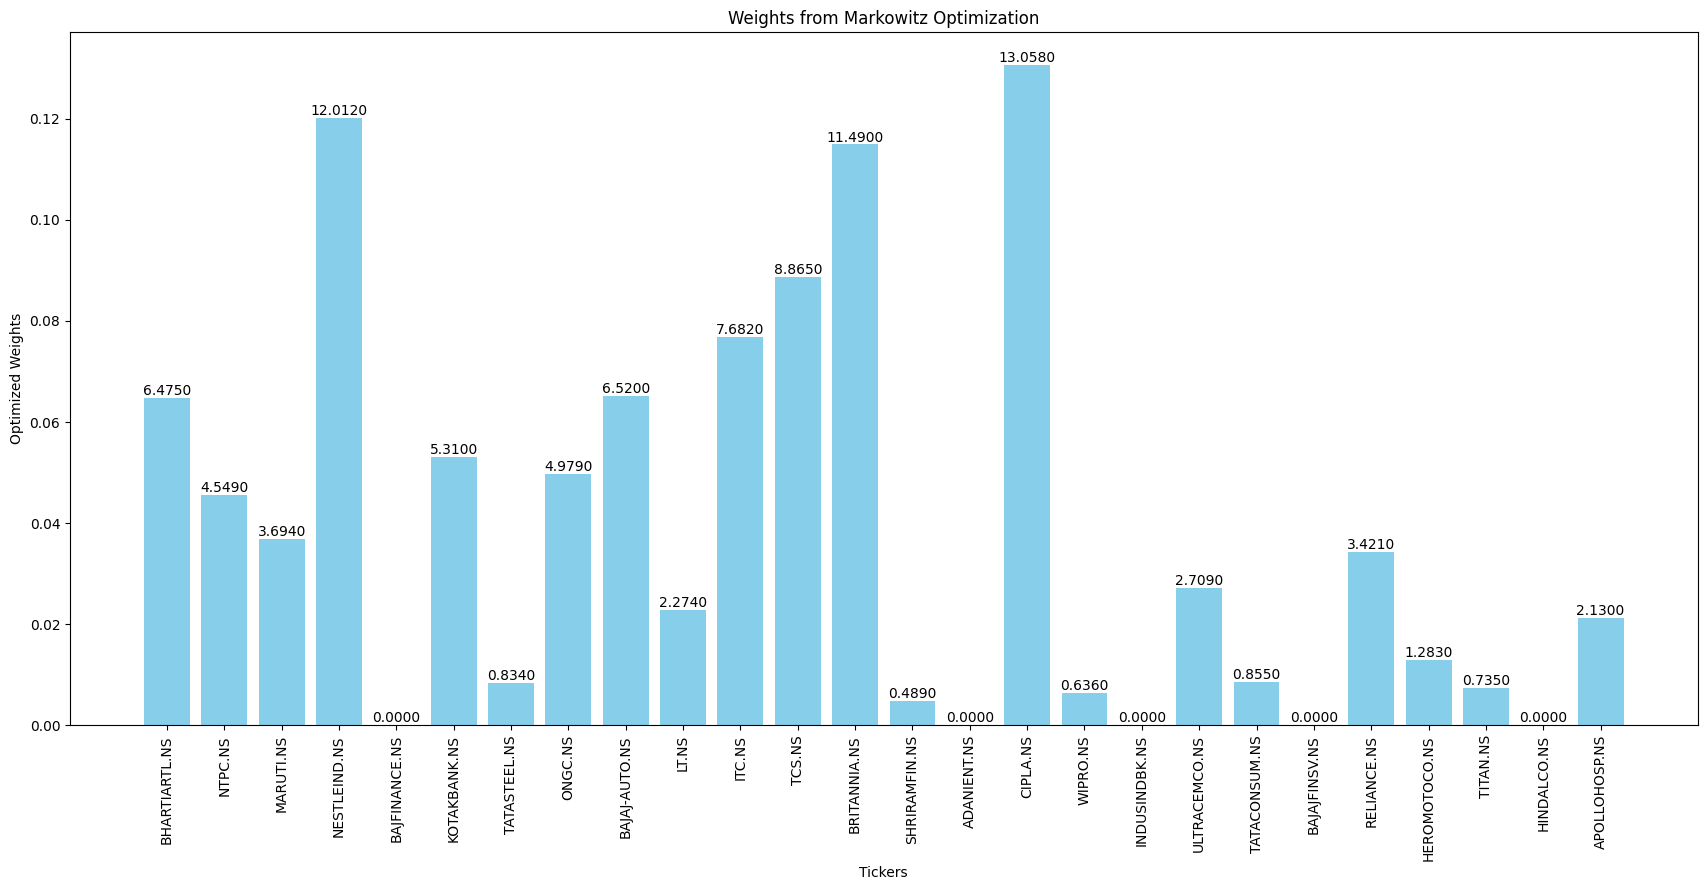

In [ ]:
# Plot the weights
plt.figure(figsize=(21, 9))
bar = plt.bar(weights_markow.keys(), weights_markow.values(), color='skyblue')
plt.xlabel("Tickers")
plt.xticks(tickers_wo_cash)
plt.ylabel("Optimized Weights")
plt.title("Weights from Markowitz Optimization")
plt.bar_label(bar, labels=[f'{x*100:,.4f}' for x in bar.datavalues])
plt.xticks(rotation=90)
plt.show()

In [ ]:
%matplotlib inline

capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_train_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(np.array(list(weights_markow.values())), returns_train_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(list(returns_train_data.index[1:]), portfolio_values, label="Markowitz Portfolio", color="blue")
plt.title("Portfolio Performance Based on Markowitz optimization - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_markow"] = portfolio_returns
# Calculate performance metrics
final_value_trg_markow = capital
total_return_trg_markow = final_value_trg_markow - initial_capital
sharpe_ratio_trg_markow = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_markow = (final_value_trg_markow / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_markow = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_markow:.2f}")
print(f"Total Return: {total_return_trg_markow:.2f}")
print(f"Annualized Return: {annualized_return_trg_markow*100 :.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_markow:.4f}")
print(f"Maximum Drawdown (%): {maxdraw_trg_markow:.4f}")

In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []


for t in range(1, len(returns_test_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(np.array(list(weights_markow.values())), returns_test_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_test_data.index[1:], portfolio_values, label="Markowitz Portfolio", color="green")
plt.title("Portfolio Performance Based on Markowitz optimization - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_markow"] = portfolio_returns

# Calculate performance metrics
returns_test_markow = pd.DataFrame(portfolio_returns)
final_value_test_markow = capital
total_return_test_markow = final_value_test_markow - initial_capital
sharpe_ratio_test_markow = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_markow = (final_value_test_markow / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_markow = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_markow:.2f}")
print(f"Total Return: {total_return_test_markow:.2f}")
print(f"Annualized Return: {annualized_return_test_markow * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_markow:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_markow:.4f}")

## **B. Kelly's Criterion for Portfolio Optimization**

In [ ]:
# We determine the weights as per Kelly's criteria

variances = returns_train_data.var()  # Variance of returns
expected_returns = returns_train_data.mean()
# Step 2: Calculate Kelly Criterion for each security
kelly_fractions = expected_returns / variances
kelly_fractions_normalized = kelly_fractions / kelly_fractions.sum()
weights_kelly = kelly_fractions_normalized

In [ ]:
# Plot the weights
plt.figure(figsize=(21, 9))
bar = plt.bar(list(weights_kelly.index), list(weights_kelly), color='skyblue')
plt.xlabel("Tickers")
plt.xticks(list(weights_kelly.index))
plt.ylabel("Optimized Weights")
plt.title("Weights from Kelly Criterion")
plt.bar_label(bar, labels=[f'{x*100:,.4f}' for x in bar.datavalues])
plt.xticks(rotation=90)
plt.show()

In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_train_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_kelly, returns_train_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="Kelly Criterion Portfolio", color="blue")
plt.title("Portfolio Performance based on Kelly Criterion - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_kelly"] = portfolio_returns

# Calculate performance metrics
final_value_trg_kelly = capital
total_return_trg_kelly = final_value_trg_kelly - initial_capital
sharpe_ratio_trg_kelly = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_kelly = (final_value_trg_kelly / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_kelly = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_kelly:.2f}")
print(f"Total Return: {total_return_trg_kelly:.2f}")
print(f"Annualized Return: {annualized_return_trg_kelly * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_kelly:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_kelly:.4f}")

In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_test_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_kelly, returns_test_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_test_data.index[1:], portfolio_values, label="Kelly Criterion Portfolio", color="green")
plt.title("Portfolio Performance based on Kelly Criterion - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_kelly"] = portfolio_returns


# Calculate performance metrics
final_value_test_kelly = capital
total_return_test_kelly = final_value_test_kelly - initial_capital
sharpe_ratio_test_kelly = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_kelly = (final_value_test_kelly / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_kelly = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_kelly:.2f}")
print(f"Total Return: {total_return_test_kelly:.2f}")
print(f"Annualized Return: {annualized_return_test_kelly * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_kelly:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_kelly:.4f}")

## **C. De Prado's Denoising Approach**

In [ ]:
N = returns_train_data.shape[1]
T = returns_train_data.shape[0]
x = returns_train_data.copy()
# code snippet 2.2 - marcenko-pastur pdf explains eigenvalues of random matrix x
cor = np.corrcoef(x, rowvar=0) # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
eVal0 , eVec0 = getPCA( cor )
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.005) #empirical pdf

# code snippet 2.3 - random matrix with signal
alpha, nCols, nFact, q = .995, N, 100, 10
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
corr0 = cov2corr(cov)
eVal01, eVec01 = getPCA(corr0)
#pdf2 = fitKDE(np.diag(eVal01), bWidth=.15) #empirical pdf

# Figure 2.1 Plot empirical:KDE and Marcenko-Pastur, and histogram
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues

eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)
nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)

#code snippet 2.3 - with random matrix with signal
######################
# Figure 2.1 Plot empirical:KDE and Marcenko-Pastur, and histogram
pdf0 = mpPDF(var0, q=x.shape[0]/float(x.shape[1]), pts=N)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues

plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
#plt.plot(pdf1.keys(), pdf1, color='g', label="Empirical:KDE")
#plt.plot(x_range, pdf2, color='b', label="Eigenvalues of random-matrix with signal")
plt.legend(loc="upper right")
plt.show()
######################

In [ ]:
# code snippet 2.5 - denoising by constant residual eigenvalue
corr1 = denoisedCorr(eVal01, eVec01, nFacts0)
eVal1, eVec1 = getPCA(corr1)

denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal01)
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

corr_detoned_denoised = detoned_corr(corr1, eVal1, eVec1)

eVal1_detoned, eVec1_detoned = getPCA(corr_detoned_denoised)
detoned_denoised_eigenvalue = np.diag(eVal1_detoned)
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal01)

plt.plot(range(0, len(detoned_denoised_eigenvalue)), np.log(detoned_denoised_eigenvalue), color='b', label="Detoned, denoised eigen-function")
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
std = np.sqrt(np.diag(returns_train_data.cov()))
cov_denoised = corr2cov(corr1, std)
weights_denoised = optPort(cov_denoised, returns_train_data.mean())

In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_train_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_denoised, returns_train_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="Denoised Portfolio", color="blue")
plt.title("Portfolio Performance based on Denoising - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_denoised"] = portfolio_returns

# Calculate performance metrics
final_value_trg_denoised = capital
total_return_trg_denoised = final_value_trg_denoised - initial_capital
sharpe_ratio_trg_denoised = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_denoised = (final_value_trg_denoised / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_denoised = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_denoised:.2f}")
print(f"Total Return: {total_return_trg_denoised:.2f}")
print(f"Annualized Return: {annualized_return_trg_denoised * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_denoised:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_denoised:.4f}")

In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_test_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_denoised, returns_test_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_test_data.index[1:], portfolio_values, label="Denoised Portfolio", color="green")
plt.title("Portfolio Performance based on Denoising - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_denoised"] = portfolio_returns

# Calculate performance metrics
final_value_test_denoised = capital
total_return_test_denoised = final_value_test_denoised - initial_capital
sharpe_ratio_test_denoised = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_denoised = (final_value_test_denoised / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_denoised = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_denoised:.2f}")
print(f"Total Return: {total_return_test_denoised:.2f}")
print(f"Annualized Return: {annualized_return_test_denoised * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_denoised:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_denoised:.4f}")

## **D. Equal-weighted Approach**

In [ ]:
weights_eq = np.ones(len(tickers_wo_cash))/len(tickers_wo_cash)

In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_train_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_eq, returns_train_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="Equal-weighted Portfolio", color="blue")
plt.title("Portfolio Performance based on Equal weights - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_eq"] = portfolio_returns

# Calculate performance metrics
final_value_trg_eq = capital
total_return_trg_eq = final_value_trg_eq - initial_capital
sharpe_ratio_trg_eq = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_eq = (final_value_trg_eq / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_eq = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_eq:.2f}")
print(f"Total Return: {total_return_trg_eq:.2f}")
print(f"Annualized Return: {annualized_return_trg_eq * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_eq:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_eq:.4f}")

In [ ]:
capital = initial_capital
capital_before_tc = initial_capital
old_capital = initial_capital
portfolio_values = []
portfolio_returns = []

for t in range(1, len(returns_test_data)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = np.dot(weights_eq, returns_test_data.iloc[t].values)

    # Update portfolio value
    capital_before_tc *= (1 + portfolio_return)
    tcost = transaction_cost * abs(capital_before_tc - old_capital)/old_capital
    capital *= (1 + portfolio_return - tcost)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    old_capital = capital

# Plot the portfolio value over time
plt.figure(figsize=(21, 8))
plt.plot(returns_test_data.index[1:], portfolio_values, label="Equal-weighted Portfolio", color="green")
plt.title("Portfolio Performance based on Equal weights - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_eq"] = portfolio_returns

# Calculate performance metrics
final_value_test_eq = capital
total_return_test_eq = final_value_test_eq - initial_capital
sharpe_ratio_test_eq = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_eq = (final_value_test_eq / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_eq = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_eq:.2f}")
print(f"Total Return: {total_return_test_eq:.2f}")
print(f"Annualized Return: {annualized_return_test_eq * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_eq:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_eq:.4f}")

## **E. A2C RL Model with TI as the state of the RL agent**

In [ ]:
stock_dimension = len(tickers)
state_space = stock_dimension

In [ ]:
env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": ti_abbreviations,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

In [ ]:
e_train_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

In [ ]:
# initialize
agent = DRLAgent(env = env_train)
model_a2c_ti = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS_TI)


In [ ]:
trained_a2c_ti = agent.train_model(model=model_a2c_ti, tb_log_name='a2c', total_timesteps=total_timesteps_)
DynaCAAST_Model['a2c_ti'] = trained_a2c_ti

In [ ]:
import time
# A2C Train Model
e_trade_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

a2c_train_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_a2c_ti, test_data = train_data_ti, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(a2c_train_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = a2c_train_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="A2C TI Portfolio", color="blue")
plt.title("Portfolio Performance based on A2C Algorithm with TI as the State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_a2c_ti"] = portfolio_returns

# Calculate performance metrics
final_value_trg_a2c_ti = capital
total_return_trg_a2c_ti = final_value_trg_a2c_ti - initial_capital
sharpe_ratio_trg_a2c_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_a2c_ti = (final_value_trg_a2c_ti / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_a2c_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_a2c_ti:.2f}")
print(f"Total Return: {total_return_trg_a2c_ti:.2f}")
print(f"Annualized Return: {annualized_return_trg_a2c_ti * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_a2c_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_a2c_ti:.4f}")

In [ ]:
# A2C Test Model
import time
e_trade_gym = StockPortfolioEnv(df = test_data_ti, **env_kwargs)
env_a2c_ti_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_ti_test'] = copy.copy(env_a2c_ti_test)
DynaCAAST_Obs['a2c_ti_test'] = obs_trade.copy()
a2c_test_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_a2c_ti, test_data = test_data_ti, test_env = env_a2c_ti_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(a2c_test_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = a2c_test_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(a2c_test_returns_ti["date"][1:], portfolio_values, label="A2C TI Portfolio", color="green")
plt.title("Portfolio Performance based on A2C Algorithm  with TI as the State- Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_a2c_ti"] = portfolio_returns

# Calculate performance metrics
final_value_test_a2c_ti = capital
total_return_test_a2c_ti = final_value_test_a2c_ti - initial_capital
sharpe_ratio_test_a2c_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_a2c_ti = (final_value_test_a2c_ti / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_a2c_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_a2c_ti:.2f}")
print(f"Total Return: {total_return_test_a2c_ti:.2f}")
print(f"Annualized Return: {annualized_return_test_a2c_ti * 100:.2f}%")
print(f"Sharpe Ratio : {sharpe_ratio_test_a2c_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_a2c_ti:.4f}")

## **F. PPO RL Model with TI as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)

model_ppo_ti = agent.get_model("ppo",model_kwargs = PPO_PARAMS_TI)

In [ ]:
trained_ppo_ti = agent.train_model(model=model_ppo_ti, tb_log_name='ppo', total_timesteps=total_timesteps_)
DynaCAAST_Model['ppo_ti'] = trained_ppo_ti

In [ ]:
# PPO Train Model
e_trade_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ppo_train_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_ppo_ti, test_data = train_data_ti, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ppo_train_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ppo_train_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="PPO TI Portfolio", color="blue")
plt.title("Portfolio Performance based on PPO Algorithm with TI as the State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_ppo_ti"] = portfolio_returns

# Calculate performance metrics
final_value_trg_ppo_ti = capital
total_return_trg_ppo_ti = final_value_trg_ppo_ti - initial_capital
sharpe_ratio_trg_ppo_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_ppo_ti = (final_value_trg_ppo_ti / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_ppo_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_ppo_ti:.2f}")
print(f"Total Return: {total_return_trg_ppo_ti:.2f}")
print(f"Annualized Return: {annualized_return_trg_ppo_ti * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_ppo_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_ppo_ti:.4f}")

In [ ]:
# PPO Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_ti, **env_kwargs)
env_ppo_ti_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_ti_test'] = copy.copy(env_ppo_ti_test)
DynaCAAST_Obs['ppo_ti_test'] = obs_trade.copy()

ppo_test_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_ppo_ti, test_data = test_data_ti, test_env = env_ppo_ti_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ppo_test_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ppo_test_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(ppo_test_returns_ti["date"][1:], portfolio_values, label="PPO TI Portfolio", color="green")
plt.title("Portfolio Performance based on PPO Algorithm  with TI as the State- Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_ppo_ti"] = portfolio_returns

# Calculate performance metrics
final_value_test_ppo_ti = capital
total_return_test_ppo_ti = final_value_test_ppo_ti - initial_capital
sharpe_ratio_test_ppo_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_ppo_ti = (final_value_test_ppo_ti / initial_capital) ** (1 / (len(ppo_test_returns_ti) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_ppo_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_ppo_ti:.2f}")
print(f"Total Return: {total_return_test_ppo_ti:.2f}")
print(f"Annualized Return: {annualized_return_test_ppo_ti * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_ppo_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_ppo_ti:.4f}")

## **G. DDPG RL Model with TI as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg_ti = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS_TI)

In [ ]:
trained_ddpg_ti = agent.train_model(model=model_ddpg_ti, tb_log_name='ddpg',  total_timesteps=total_timesteps_)
DynaCAAST_Model['ddpg_ti'] = trained_ddpg_ti

In [ ]:
# DDPG Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ddpg_train_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_ddpg_ti, test_data = train_data_ti, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ddpg_train_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ddpg_train_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="DDPG TI Portfolio", color="blue")
plt.title("Portfolio Performance based on DDPG Algorithm  with TI as the State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_ddpg_ti"] = portfolio_returns

# Calculate performance metrics
final_value_trg_ddpg_ti = capital
total_return_trg_ddpg_ti = final_value_trg_ddpg_ti - initial_capital
sharpe_ratio_trg_ddpg_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_ddpg_ti = (final_value_trg_ddpg_ti / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_ddpg_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_ddpg_ti:.2f}")
print(f"Total Return: {total_return_trg_ddpg_ti:.2f}")
print(f"Annualized Return: {annualized_return_trg_ddpg_ti * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_ddpg_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_ddpg_ti:.4f}")

In [ ]:
# DDPG Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_ti, **env_kwargs)
env_ddpg_ti_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_ti_test'] = copy.copy(env_ddpg_ti_test)
DynaCAAST_Obs['ddpg_ti_test'] = obs_trade.copy()
ddpg_test_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_ddpg_ti, test_data = test_data_ti, test_env = env_ddpg_ti_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ddpg_test_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ddpg_test_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(ddpg_test_returns_ti["date"][1:], portfolio_values, label="DDPG TI Portfolio", color="green")
plt.title("Portfolio Performance based on DDPG Algorithm with TI as the State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_ddpg_ti"] = portfolio_returns

# Calculate performance metrics
final_value_test_ddpg_ti = capital
total_return_test_ddpg_ti = final_value_test_ddpg_ti - initial_capital
sharpe_ratio_test_ddpg_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_ddpg_ti = (final_value_test_ddpg_ti / initial_capital) ** (1 / (len(ddpg_test_returns_ti) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_ddpg_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_ddpg_ti:.2f}")
print(f"Total Return: {total_return_test_ddpg_ti:.2f}")
print(f"Annualized Return: {annualized_return_test_ddpg_ti * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_ddpg_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_ddpg_ti:.4f}")

## **H. SAC RL Model with TI as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_sac_ti = agent.get_model("sac",model_kwargs = SAC_PARAMS_TI)

In [ ]:
trained_sac_ti = agent.train_model(model=model_sac_ti, tb_log_name='sac', total_timesteps=total_timesteps_)
DynaCAAST_Model['sac_ti'] = trained_sac_ti

In [ ]:
#  SAC Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

sac_train_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_sac_ti, test_data = train_data_ti, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(sac_train_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = sac_train_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="SAC TI Portfolio", color="blue")
plt.title("Portfolio Performance based on SAC Algorithm  with TI as the State- Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_sac_ti"] = portfolio_returns

# Calculate performance metrics
final_value_trg_sac_ti = capital
total_return_trg_sac_ti = final_value_trg_sac_ti - initial_capital
sharpe_ratio_trg_sac_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_sac_ti = (final_value_trg_sac_ti / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_sac_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_sac_ti:.2f}")
print(f"Total Return: {total_return_trg_sac_ti:.2f}")
print(f"Annualized Return: {annualized_return_trg_sac_ti * 100:.2f}%")
print(f"Sharpe Ratio Kelly: {sharpe_ratio_trg_sac_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_sac_ti:.4f}")

In [ ]:
# SAC Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_ti, **env_kwargs)
env_sac_ti_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_ti_test'] = copy.copy(env_sac_ti_test)
DynaCAAST_Obs['sac_ti_test'] = copy.copy(obs_trade)
sac_test_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_sac_ti, test_data = test_data_ti, test_env = env_sac_ti_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(sac_test_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = sac_test_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(sac_test_returns_ti["date"][1:], portfolio_values, label="SAC TI Portfolio", color="green")
plt.title("Portfolio Performance based on SAC Algorithm  with TI as the State- Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_sac_ti"] = portfolio_returns

# Calculate performance metrics
final_value_test_sac_ti = capital
total_return_test_sac_ti = final_value_test_sac_ti - initial_capital
sharpe_ratio_test_sac_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_sac_ti = (final_value_test_sac_ti / initial_capital) ** (1 / (len(sac_test_returns_ti) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_sac_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_sac_ti:.2f}")
print(f"Total Return: {total_return_test_sac_ti:.2f}")
print(f"Annualized Return: {annualized_return_test_sac_ti * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_sac_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_sac_ti:.4f}")

## **I. TD3 RL Model with TI as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_td3_ti = agent.get_model("td3",model_kwargs = TD3_PARAMS_TI)

In [ ]:
trained_td3_ti = agent.train_model(model=model_td3_ti, tb_log_name='td3', total_timesteps=total_timesteps_)
DynaCAAST_Model['td3_ti'] = trained_td3_ti

In [ ]:
# td3 Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

td3_train_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_td3_ti, test_data = train_data_ti, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(td3_train_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = td3_train_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="TD3 TI Portfolio", color="blue")
plt.title("Portfolio Performance based on TD3 Algorithm  with TI as the State- Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_td3_ti"] = portfolio_returns

# Calculate performance metrics
final_value_trg_td3_ti = capital
total_return_trg_td3_ti = final_value_trg_td3_ti - initial_capital
sharpe_ratio_trg_td3_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_td3_ti = (final_value_trg_td3_ti / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_td3_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_td3_ti:.2f}")
print(f"Total Return: {total_return_trg_td3_ti:.2f}")
print(f"Annualized Return: {annualized_return_trg_td3_ti * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_td3_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_td3_ti:.4f}")

In [ ]:
# TD3 Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_ti, **env_kwargs)
env_td3_ti_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_ti_test'] = copy.copy(env_td3_ti_test)
DynaCAAST_Obs['td3_ti_test'] = obs_trade.copy()

td3_test_returns_ti, _ = DRLAgent.DRL_prediction(model=trained_td3_ti, test_data = test_data_ti, test_env = env_td3_ti_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(td3_test_returns_ti)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = td3_test_returns_ti['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(td3_test_returns_ti["date"][1:], portfolio_values, label="TD3 TI Portfolio", color="green")
plt.title("Portfolio Performance based on TD3 Algorithm with TI as the State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_td3_ti"] = portfolio_returns

# Calculate performance metrics
final_value_test_td3_ti = capital
total_return_test_td3_ti = final_value_test_td3_ti - initial_capital
sharpe_ratio_test_td3_ti = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_td3_ti = (final_value_test_td3_ti / initial_capital) ** (1 / (len(td3_test_returns_ti) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_td3_ti = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_td3_ti:.2f}")
print(f"Total Return: {total_return_test_td3_ti:.2f}")
print(f"Annualized Return: {annualized_return_test_td3_ti * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_td3_ti:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_td3_ti:.4f}")

## **J. Performance Analysis of RL agents using TI as their states**

In [ ]:
returns_train = prices_train_data.pct_change() # get the assets daily returns
returns_test = prices_test_data.pct_change()


a2c_train_cum_returns_ti = (1 + a2c_train_returns_ti.copy().reset_index(drop=True).set_index(['date'])).cumprod()
a2c_train_cum_returns_ti = a2c_train_cum_returns_ti['daily_return']
a2c_train_cum_returns_ti.name = 'A2C TI Model'

ppo_train_cum_returns_ti = (1 + ppo_train_returns_ti.copy().reset_index(drop=True).set_index(['date'])).cumprod()
ppo_train_cum_returns_ti = ppo_train_cum_returns_ti['daily_return']
ppo_train_cum_returns_ti.name = 'PPO TI Model'

ddpg_train_cum_returns_ti = (1 + ddpg_train_returns_ti.copy().reset_index(drop=True).set_index(['date'])).cumprod()
ddpg_train_cum_returns_ti = ddpg_train_cum_returns_ti['daily_return']
ddpg_train_cum_returns_ti.name = 'DDPG TI Model'

sac_train_cum_returns_ti = (1 + sac_train_returns_ti.copy().reset_index(drop=True).set_index(['date'])).cumprod()
sac_train_cum_returns_ti = sac_train_cum_returns_ti['daily_return']
sac_train_cum_returns_ti.name = 'SAC TI Model'

td3_train_cum_returns_ti = (1 + td3_train_returns_ti.copy().reset_index(drop=True).set_index(['date'])).cumprod()
td3_train_cum_returns_ti = td3_train_cum_returns_ti['daily_return']
td3_train_cum_returns_ti.name = 'TD3 TI Model'

date_list = list(ddpg_train_cum_returns_ti.index)

In [ ]:
%matplotlib inline

# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
a2c_train_cum_returns_ti.plot(ax=ax, color='blue', alpha=0.4)
ppo_train_cum_returns_ti.plot(ax=ax, color='green', alpha=0.4)
ddpg_train_cum_returns_ti.plot(ax=ax, color='skyblue', alpha=0.4)
sac_train_cum_returns_ti.plot(ax=ax, color='red', alpha=0.4)
td3_train_cum_returns_ti.plot(ax=ax, color='black', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Cumulative return");
ax.set_title("Performance on the training data with Technical Indicators as the state", fontsize=14);
plt.show()

In [ ]:
%matplotlib inline

# get the culmulative returns for each portfolio

a2c_test_cum_returns_ti = (1 + a2c_test_returns_ti['daily_return']).cumprod()
a2c_test_cum_returns_ti.name = 'A2C TI Model'
a2c_test_cum_returns_ti.index = a2c_test_returns_ti['date']

ppo_test_cum_returns_ti = (1 + ppo_test_returns_ti['daily_return']).cumprod()
ppo_test_cum_returns_ti.name = 'PPO TI Model'
ppo_test_cum_returns_ti.index = ppo_test_returns_ti['date']

ddpg_test_cum_returns_ti = (1 + ddpg_test_returns_ti['daily_return']).cumprod()
ddpg_test_cum_returns_ti.name = 'DDPG TI Model'
ddpg_test_cum_returns_ti.index = ddpg_test_returns_ti['date']

sac_test_cum_returns_ti = (1 + sac_test_returns_ti['daily_return']).cumprod()
sac_test_cum_returns_ti.name = 'SAC TI Model'
sac_test_cum_returns_ti.index = sac_test_returns_ti['date']

td3_test_cum_returns_ti = (1 + td3_test_returns_ti['daily_return']).cumprod()
td3_test_cum_returns_ti.name = 'TD3 TI Model'
td3_test_cum_returns_ti.index = td3_test_returns_ti['date']


In [ ]:
%matplotlib inline
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
a2c_test_cum_returns_ti.plot(ax=ax, color='blue', alpha=.4)
ppo_test_cum_returns_ti.plot(ax=ax, color='green', alpha=.4)
ddpg_test_cum_returns_ti.plot(ax=ax, color='skyblue', alpha=.4)
sac_test_cum_returns_ti.plot(ax=ax, color='red', alpha=0.4)
td3_test_cum_returns_ti.plot(ax=ax, color='black', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Cumulative return");
ax.set_title("Performance on the testing data with Technical Indicators as the state", fontsize=14);

## **K. A2C RL Model with Lagged Returns as the state of the RL agent**

In [ ]:
stock_dimension = len(tickers)
state_space = stock_dimension

In [ ]:
env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": return_lags,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

In [ ]:
e_train_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

In [ ]:
# initialize
agent = DRLAgent(env = env_train)
model_a2c_ret = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS_RET)


In [ ]:
trained_a2c_ret = agent.train_model(model=model_a2c_ret, tb_log_name='a2c', total_timesteps=total_timesteps_)
DynaCAAST_Model['a2c_ret'] = trained_a2c_ret

In [ ]:
import time
# A2C Train Model
e_trade_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

a2c_train_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_a2c_ret, test_data = train_data_ret, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(a2c_train_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = a2c_train_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="A2C RET Portfolio", color="blue")
plt.title("Portfolio Performance based on A2C Algorithm on Lagged Returns State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_a2c_ret"] = portfolio_returns

# Calculate performance metrics
final_value_trg_a2c_ret = capital
total_return_trg_a2c_ret = final_value_trg_a2c_ret - initial_capital
sharpe_ratio_trg_a2c_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_a2c_ret = (final_value_trg_a2c_ret / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_a2c_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_a2c_ret:.2f}")
print(f"Total Return: {total_return_trg_a2c_ret:.2f}")
print(f"Annualized Return: {annualized_return_trg_a2c_ret * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_a2c_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_a2c_ret:.4f}")

In [ ]:
# A2C Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_ret, **env_kwargs)
env_a2c_ret_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_ret_test'] = copy.copy(env_a2c_ret_test)
DynaCAAST_Obs['a2c_ret_test'] = obs_trade.copy()
a2c_test_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_a2c_ret, test_data = test_data_ret, test_env = env_a2c_ret_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(a2c_test_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = a2c_test_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(a2c_test_returns_ret["date"][1:], portfolio_values, label="A2C RET Portfolio", color="green")
plt.title("Portfolio Performance based on A2C Algorithm with Lagged Returns as the state - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_a2c_ret"] = portfolio_returns

# Calculate performance metrics
final_value_test_a2c_ret = capital
total_return_test_a2c_ret = final_value_test_a2c_ret - initial_capital
sharpe_ratio_test_a2c_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_a2c_ret = (final_value_test_a2c_ret / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_a2c_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_a2c_ret:.2f}")
print(f"Total Return: {total_return_test_a2c_ret:.2f}")
print(f"Annualized Return: {annualized_return_test_a2c_ret * 100:.2f}%")
print(f"Sharpe Ratio : {sharpe_ratio_test_a2c_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_a2c_ret:.4f}")

## **L. PPO RL Model with Lagged Returns as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)

model_ppo_ret = agent.get_model("ppo", model_kwargs = PPO_PARAMS_RET)

In [ ]:
trained_ppo_ret = agent.train_model(model=model_ppo_ret, tb_log_name='ppo', total_timesteps=total_timesteps_)
DynaCAAST_Model['ppo_ret'] = trained_ppo_ret

In [ ]:
# PPO Train Model
e_trade_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ppo_train_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_ppo_ret, test_data = train_data_ret, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ppo_train_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ppo_train_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="PPO RET Portfolio", color="blue")
plt.title("Portfolio Performance based on PPO Algorithm with Lagged Returns as the state  - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_ppo_ret"] = portfolio_returns

# Calculate performance metrics
final_value_trg_ppo_ret = capital
total_return_trg_ppo_ret = final_value_trg_ppo_ret - initial_capital
sharpe_ratio_trg_ppo_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_ppo_ret = (final_value_trg_ppo_ret / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_ppo_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_ppo_ret:.2f}")
print(f"Total Return: {total_return_trg_ppo_ret:.2f}")
print(f"Annualized Return: {annualized_return_trg_ppo_ret * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_ppo_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_ppo_ret:.4f}")

In [ ]:
# PPO Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_ret, **env_kwargs)
env_ppo_ret_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_ret_test'] = copy.copy(env_ppo_ret_test)
DynaCAAST_Obs['ppo_ret_test'] = obs_trade.copy()
ppo_test_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_ppo_ret, test_data = test_data_ret, test_env = env_ppo_ret_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ppo_test_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ppo_test_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(ppo_test_returns_ti["date"][1:], portfolio_values, label="PPO RET Portfolio", color="green")
plt.title("Portfolio Performance based on PPO Algorithm with Lagged Returns as the state  - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_ppo_ret"] = portfolio_returns

# Calculate performance metrics
final_value_test_ppo_ret = capital
total_return_test_ppo_ret = final_value_test_ppo_ret - initial_capital
sharpe_ratio_test_ppo_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_ppo_ret = (final_value_test_ppo_ret / initial_capital) ** (1 / (len(ppo_test_returns_ret) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_ppo_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_ppo_ret:.2f}")
print(f"Total Return: {total_return_test_ppo_ret:.2f}")
print(f"Annualized Return: {annualized_return_test_ppo_ret * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_ppo_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_ppo_ret:.4f}")

## **M. DDPG RL Model with Lagged Returns as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg_ret = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS_RET)

In [ ]:
trained_ddpg_ret = agent.train_model(model= model_ddpg_ret, tb_log_name='ddpg',  total_timesteps=total_timesteps_)
DynaCAAST_Model['ddpg_ret'] = trained_ddpg_ret

In [ ]:
# DDPG Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ddpg_train_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_ddpg_ret, test_data = train_data_ret, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ddpg_train_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ddpg_train_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="DDPG RET Portfolio", color="blue")
plt.title("Portfolio Performance based on DDPG Algorithm with Lagged Returns as the state  - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_ddpg_ret"] = portfolio_returns

# Calculate performance metrics
final_value_trg_ddpg_ret = capital
total_return_trg_ddpg_ret = final_value_trg_ddpg_ret - initial_capital
sharpe_ratio_trg_ddpg_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_ddpg_ret = (final_value_trg_ddpg_ret / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_ddpg_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_ddpg_ret:.2f}")
print(f"Total Return: {total_return_trg_ddpg_ret:.2f}")
print(f"Annualized Return: {annualized_return_trg_ddpg_ret * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_ddpg_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_ddpg_ret:.4f}")

In [ ]:
# DDPG Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_ret, **env_kwargs)
env_ddpg_ret_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_ret_test'] = copy.copy(env_ddpg_ret_test)
DynaCAAST_Obs['ddpg_ret_test'] = obs_trade.copy()
ddpg_test_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_ddpg_ret, test_data = test_data_ret, test_env = env_ddpg_ret_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ddpg_test_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ddpg_test_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(ddpg_test_returns_ret["date"][1:], portfolio_values, label="DDPG RET Portfolio", color="green")
plt.title("Portfolio Performance based on DDPG Algorithm with Lagged Returns as the state  - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_ddpg_ret"] = portfolio_returns

# Calculate performance metrics
final_value_test_ddpg_ret = capital
total_return_test_ddpg_ret = final_value_test_ddpg_ret - initial_capital
sharpe_ratio_test_ddpg_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_ddpg_ret = (final_value_test_ddpg_ret / initial_capital) ** (1 / (len(ddpg_test_returns_ret) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_ddpg_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_ddpg_ret:.2f}")
print(f"Total Return: {total_return_test_ddpg_ret:.2f}")
print(f"Annualized Return: {annualized_return_test_ddpg_ret * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_ddpg_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_ddpg_ret:.4f}")

## **N. SAC RL Model with Lagged Returns as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_sac_ret = agent.get_model("sac",model_kwargs = SAC_PARAMS_RET)

In [ ]:
trained_sac_ret = agent.train_model(model=model_sac_ret, tb_log_name='sac', total_timesteps=total_timesteps_)
DynaCAAST_Model['sac_ret'] = trained_sac_ret

In [ ]:
#  SAC Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

sac_train_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_sac_ret, test_data = train_data_ret, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(sac_train_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = sac_train_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="SAC RET Portfolio", color="blue")
plt.title("Portfolio Performance based on SAC Algorithm with Lagged Returns as the state  - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_sac_ret"] = portfolio_returns

# Calculate performance metrics
final_value_trg_sac_ret = capital
total_return_trg_sac_ret = final_value_trg_sac_ret - initial_capital
sharpe_ratio_trg_sac_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_sac_ret = (final_value_trg_sac_ret / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_sac_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_sac_ret:.2f}")
print(f"Total Return: {total_return_trg_sac_ret:.2f}")
print(f"Annualized Return: {annualized_return_trg_sac_ret * 100:.2f}%")
print(f"Sharpe Ratio Kelly: {sharpe_ratio_trg_sac_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_sac_ret:.4f}")

In [ ]:
# SAC Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_ret, **env_kwargs)
env_sac_ret_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_ret_test'] = copy.copy(env_sac_ret_test)
DynaCAAST_Obs['sac_ret_test'] = obs_trade.copy()
sac_test_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_sac_ret, test_data = test_data_ret, test_env = env_sac_ret_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(sac_test_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = sac_test_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(sac_test_returns_ret["date"][1:], portfolio_values, label="SAC RET Portfolio", color="green")
plt.title("Portfolio Performance based on SAC Algorithm with Lagged Returns as the state  - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_sac_ret"] = portfolio_returns

# Calculate performance metrics
final_value_test_sac_ret = capital
total_return_test_sac_ret = final_value_test_sac_ret - initial_capital
sharpe_ratio_test_sac_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_sac_ret = (final_value_test_sac_ret / initial_capital) ** (1 / (len(sac_test_returns_ret) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_sac_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_sac_ret:.2f}")
print(f"Total Return: {total_return_test_sac_ret:.2f}")
print(f"Annualized Return: {annualized_return_test_sac_ret * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_sac_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_sac_ret:.4f}")

## **O. TD3 RL Model with Lagged Returns as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_td3_ret = agent.get_model("td3", model_kwargs = TD3_PARAMS_RET)

In [ ]:
trained_td3_ret = agent.train_model(model=model_td3_ret, tb_log_name='td3', total_timesteps=total_timesteps_)
DynaCAAST_Model['td3_ret'] = trained_td3_ret

In [ ]:
# td3 Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

td3_train_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_td3_ret, test_data = train_data_ret, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(td3_train_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = td3_train_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="TD3 RET Portfolio", color="blue")
plt.title("Portfolio Performance based on TD3 Algorithm with Lagged Returns as the state  - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_td3_ret"] = portfolio_returns

# Calculate performance metrics
final_value_trg_td3_ret = capital
total_return_trg_td3_ret = final_value_trg_td3_ret - initial_capital
sharpe_ratio_trg_td3_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_td3_ret = (final_value_trg_td3_ret / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_td3_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_td3_ret:.2f}")
print(f"Total Return: {total_return_trg_td3_ret:.2f}")
print(f"Annualized Return: {annualized_return_trg_td3_ret * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_td3_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_td3_ret:.4f}")

In [ ]:
# TD3 Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_ret, **env_kwargs)
env_td3_ret_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_ret_test'] = copy.copy(env_td3_ret_test)
DynaCAAST_Obs['td3_ret_test'] = obs_trade.copy()
td3_test_returns_ret, _ = DRLAgent.DRL_prediction(model=trained_td3_ret, test_data = test_data_ret, test_env = env_td3_ret_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(td3_test_returns_ret)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = td3_test_returns_ret['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(td3_test_returns_ret["date"][1:], portfolio_values, label="TD3 RET Portfolio", color="green")
plt.title("Portfolio Performance based on TD3 Algorithm with Lagged Returns as the state  - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_td3_ret"] = portfolio_returns

# Calculate performance metrics
final_value_test_td3_ret = capital
total_return_test_td3_ret = final_value_test_td3_ret - initial_capital
sharpe_ratio_test_td3_ret = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_td3_ret = (final_value_test_td3_ret / initial_capital) ** (1 / (len(td3_test_returns_ret) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_td3_ret = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_td3_ret:.2f}")
print(f"Total Return: {total_return_test_td3_ret:.2f}")
print(f"Annualized Return: {annualized_return_test_td3_ret * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_td3_ret:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_td3_ret:.4f}")

## **P. Performance Analysis of RL agents using Lagged Returns as their states**

In [ ]:
returns_train = prices_train_data.pct_change() # get the assets daily returns
returns_test = prices_test_data.pct_change()


a2c_train_cum_returns_ret = (1 + a2c_train_returns_ret.copy().reset_index(drop=True).set_index(['date'])).cumprod()
a2c_train_cum_returns_ret = a2c_train_cum_returns_ret['daily_return']
a2c_train_cum_returns_ret.name = 'A2C RET Model'

ppo_train_cum_returns_ret = (1 + ppo_train_returns_ret.copy().reset_index(drop=True).set_index(['date'])).cumprod()
ppo_train_cum_returns_ret = ppo_train_cum_returns_ret['daily_return']
ppo_train_cum_returns_ret.name = 'PPO RET Model'

ddpg_train_cum_returns_ret = (1 + ddpg_train_returns_ret.copy().reset_index(drop=True).set_index(['date'])).cumprod()
ddpg_train_cum_returns_ret = ddpg_train_cum_returns_ret['daily_return']
ddpg_train_cum_returns_ret.name = 'DDPG RET Model'

sac_train_cum_returns_ret = (1 + sac_train_returns_ret.copy().reset_index(drop=True).set_index(['date'])).cumprod()
sac_train_cum_returns_ret = sac_train_cum_returns_ret['daily_return']
sac_train_cum_returns_ret.name = 'SAC RET Model'

td3_train_cum_returns_ret = (1 + td3_train_returns_ret.copy().reset_index(drop=True).set_index(['date'])).cumprod()
td3_train_cum_returns_ret = td3_train_cum_returns_ret['daily_return']
td3_train_cum_returns_ret.name = 'TD3 RET Model'

date_list = list(ddpg_train_cum_returns_ret.index)

In [ ]:
%matplotlib inline

# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
a2c_train_cum_returns_ret.plot(ax=ax, color='blue', alpha=0.4)
ppo_train_cum_returns_ret.plot(ax=ax, color='green', alpha=0.4)
ddpg_train_cum_returns_ret.plot(ax=ax, color='skyblue', alpha=0.4)
sac_train_cum_returns_ret.plot(ax=ax, color='red', alpha=0.4)
td3_train_cum_returns_ret.plot(ax=ax, color='black', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Cumulative return");
ax.set_title("Performance on the training data with the Return lags as the State", fontsize=14);
plt.show()

In [ ]:
%matplotlib inline

# get the culmulative returns for each portfolio

a2c_test_cum_returns_ret = (1 + a2c_test_returns_ret['daily_return']).cumprod()
a2c_test_cum_returns_ret.name = 'A2C RET Model'
a2c_test_cum_returns_ret.index = a2c_test_returns_ret['date']

ppo_test_cum_returns_ret = (1 + ppo_test_returns_ret['daily_return']).cumprod()
ppo_test_cum_returns_ret.name = 'PPO RET Model'
ppo_test_cum_returns_ret.index = ppo_test_returns_ret['date']

ddpg_test_cum_returns_ret = (1 + ddpg_test_returns_ret['daily_return']).cumprod()
ddpg_test_cum_returns_ret.name = 'DDPG RET Model'
ddpg_test_cum_returns_ret.index = ddpg_test_returns_ret['date']

sac_test_cum_returns_ret = (1 + sac_test_returns_ret['daily_return']).cumprod()
sac_test_cum_returns_ret.name = 'SAC RET Model'
sac_test_cum_returns_ret.index = sac_test_returns_ret['date']

td3_test_cum_returns_ret = (1 + td3_test_returns_ret['daily_return']).cumprod()
td3_test_cum_returns_ret.name = 'TD3 RET Model'
td3_test_cum_returns_ret.index = td3_test_returns_ret['date']


In [ ]:
%matplotlib inline
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
a2c_test_cum_returns_ret.plot(ax=ax, color='blue', alpha=.4)
ppo_test_cum_returns_ret.plot(ax=ax, color='green', alpha=.4)
ddpg_test_cum_returns_ret.plot(ax=ax, color='skyblue', alpha=.4)
sac_test_cum_returns_ret.plot(ax=ax, color='red', alpha=0.4)
td3_test_cum_returns_ret.plot(ax=ax, color='black', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Cumulative return");
ax.set_title("Performance on the testing data with the Return lags as the State", fontsize=14);

## **Q. A2C RL Model with LSTM predictions as the state of the RL agent**

In [ ]:
stock_dimension = len(tickers)
state_space = stock_dimension

In [ ]:
env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": lstm_fcst,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

In [ ]:
e_train_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

In [ ]:
# initialize
agent = DRLAgent(env = env_train)
model_a2c_lstm = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS_LSTM)


In [ ]:
trained_a2c_lstm = agent.train_model(model=model_a2c_lstm, tb_log_name='a2c', total_timesteps=total_timesteps_)
DynaCAAST_Model['a2c_lstm'] = trained_a2c_lstm

In [ ]:
import time
# A2C Train Model
e_trade_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

a2c_train_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_a2c_lstm, test_data = train_data_lstm, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(a2c_train_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = a2c_train_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="A2C with LSTM as the State Portfolio", color="blue")
plt.title("Portfolio Performance based on A2C Algorithm  with LSTM as the State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_a2c_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_trg_a2c_lstm = capital
total_return_trg_a2c_lstm = final_value_trg_a2c_lstm - initial_capital
sharpe_ratio_trg_a2c_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_a2c_lstm = (final_value_trg_a2c_lstm / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_a2c_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_a2c_lstm:.2f}")
print(f"Total Return: {total_return_trg_a2c_lstm:.2f}")
print(f"Annualized Return: {annualized_return_trg_a2c_lstm * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_a2c_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_a2c_lstm:.4f}")

In [ ]:
# A2C Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_lstm, **env_kwargs)
env_a2c_lstm_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_lstm_test'] = copy.copy(env_a2c_lstm_test)
DynaCAAST_Obs['a2c_lstm_test'] = obs_trade.copy()
a2c_test_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_a2c_lstm, test_data = test_data_lstm, test_env = env_a2c_lstm_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(a2c_test_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = a2c_test_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(a2c_test_returns_lstm["date"][1:], portfolio_values, label="A2C Portfolio  with LSTM as the State", color="green")
plt.title("Portfolio Performance based on A2C Algorithm  with LSTM as the State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_a2c_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_test_a2c_lstm = capital
total_return_test_a2c_lstm = final_value_test_a2c_lstm - initial_capital
sharpe_ratio_test_a2c_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_a2c_lstm = (final_value_test_a2c_lstm / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_a2c_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_a2c_lstm:.2f}")
print(f"Total Return: {total_return_test_a2c_lstm:.2f}")
print(f"Annualized Return: {annualized_return_test_a2c_lstm * 100:.2f}%")
print(f"Sharpe Ratio : {sharpe_ratio_test_a2c_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_a2c_lstm:.4f}")

## **R. PPO RL Model with LSTM predictions as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)

model_ppo_lstm = agent.get_model("ppo", model_kwargs = PPO_PARAMS_LSTM)

In [ ]:
trained_ppo_lstm = agent.train_model(model=model_ppo_lstm, tb_log_name='ppo', total_timesteps=total_timesteps_)
DynaCAAST_Model['ppo_lstm'] = trained_ppo_lstm

In [ ]:
# PPO Train Model
e_trade_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ppo_train_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_ppo_lstm, test_data = train_data_lstm, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ppo_train_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ppo_train_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="PPO Portfolio with LSTM as the State ", color="blue")
plt.title("Portfolio Performance based on PPO Algorithm  with LSTM as the State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_ppo_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_trg_ppo_lstm = capital
total_return_trg_ppo_lstm = final_value_trg_ppo_lstm - initial_capital
sharpe_ratio_trg_ppo_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_ppo_lstm = (final_value_trg_ppo_lstm / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_ppo_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_ppo_lstm:.2f}")
print(f"Total Return: {total_return_trg_ppo_lstm:.2f}")
print(f"Annualized Return: {annualized_return_trg_ppo_lstm * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_ppo_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_ppo_lstm:.4f}")

In [ ]:
# PPO Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_lstm, **env_kwargs)
env_ppo_lstm_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_lstm_test'] = copy.copy(env_ppo_lstm_test)
DynaCAAST_Obs['ppo_lstm_test'] = obs_trade.copy()
ppo_test_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_ppo_lstm, test_data = test_data_lstm, test_env = env_ppo_lstm_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ppo_test_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ppo_test_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(ppo_test_returns_lstm["date"][1:], portfolio_values, label="PPO Portfolio with LSTM as the State", color="green")
plt.title("Portfolio Performance based on PPO Algorithm with LSTM as the State  - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_ppo_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_test_ppo_lstm = capital
total_return_test_ppo_lstm = final_value_test_ppo_lstm - initial_capital
sharpe_ratio_test_ppo_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_ppo_lstm = (final_value_test_ppo_lstm / initial_capital) ** (1 / (len(ppo_test_returns_lstm) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_ppo_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_ppo_lstm:.2f}")
print(f"Total Return: {total_return_test_ppo_lstm:.2f}")
print(f"Annualized Return: {annualized_return_test_ppo_lstm * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_ppo_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_ppo_lstm:.4f}")

## **S. DDPG RL Model with LSTM predictions as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg_lstm = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS_LSTM)

In [ ]:
trained_ddpg_lstm = agent.train_model(model= model_ddpg_lstm, tb_log_name='ddpg',  total_timesteps=total_timesteps_)
DynaCAAST_Model['ddpg_lstm'] = trained_ddpg_lstm

In [ ]:
# DDPG Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ddpg_train_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_ddpg_lstm, test_data = train_data_lstm, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ddpg_train_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ddpg_train_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="DDPG Portfolio with LSTM as the State ", color="blue")
plt.title("Portfolio Performance based on DDPG Algorithm with LSTM as the State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_ddpg_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_trg_ddpg_lstm = capital
total_return_trg_ddpg_lstm = final_value_trg_ddpg_lstm - initial_capital
sharpe_ratio_trg_ddpg_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_ddpg_lstm = (final_value_trg_ddpg_lstm / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_ddpg_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_ddpg_lstm:.2f}")
print(f"Total Return: {total_return_trg_ddpg_lstm:.2f}")
print(f"Annualized Return: {annualized_return_trg_ddpg_lstm * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_ddpg_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_ddpg_lstm:.4f}")

In [ ]:
# DDPG Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_lstm, **env_kwargs)
env_ddpg_lstm_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_lstm_test'] = copy.copy(env_ddpg_lstm_test)
DynaCAAST_Obs['ddpg_lstm_test'] = obs_trade.copy()
ddpg_test_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_ddpg_lstm, test_data = test_data_lstm, test_env = env_ddpg_lstm_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ddpg_test_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ddpg_test_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(ddpg_test_returns_lstm["date"][1:], portfolio_values, label="DDPG Portfolio with LSTM as State", color="green")
plt.title("Portfolio Performance based on DDPG Algorithm with LSTM as State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_ddpg_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_test_ddpg_lstm = capital
total_return_test_ddpg_lstm = final_value_test_ddpg_lstm - initial_capital
sharpe_ratio_test_ddpg_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_ddpg_lstm = (final_value_test_ddpg_lstm / initial_capital) ** (1 / (len(ddpg_test_returns_lstm) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_ddpg_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_ddpg_lstm:.2f}")
print(f"Total Return: {total_return_test_ddpg_lstm:.2f}")
print(f"Annualized Return: {annualized_return_test_ddpg_lstm * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_ddpg_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_ddpg_lstm:.4f}")

## **T. SAC RL Model with LSTM predictions as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_sac_lstm = agent.get_model("sac",model_kwargs = SAC_PARAMS_LSTM)

In [ ]:
trained_sac_lstm = agent.train_model(model=model_sac_lstm, tb_log_name='sac', total_timesteps=total_timesteps_)
DynaCAAST_Model['sac_lstm'] = trained_sac_lstm

In [ ]:
#  SAC Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

sac_train_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_sac_lstm, test_data = train_data_lstm, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(sac_train_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = sac_train_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="SAC Portfolio with LSTM as State", color="blue")
plt.title("Portfolio Performance based on SAC Algorithm with LSTM as State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_sac_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_trg_sac_lstm = capital
total_return_trg_sac_lstm = final_value_trg_sac_lstm - initial_capital
sharpe_ratio_trg_sac_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_sac_lstm = (final_value_trg_sac_lstm / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_sac_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_sac_lstm:.2f}")
print(f"Total Return: {total_return_trg_sac_lstm:.2f}")
print(f"Annualized Return: {annualized_return_trg_sac_lstm * 100:.2f}%")
print(f"Sharpe Ratio Kelly: {sharpe_ratio_trg_sac_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_sac_lstm:.4f}")

In [ ]:
# SAC Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_lstm, **env_kwargs)
env_sac_lstm_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_lstm_test'] = copy.copy(env_sac_lstm_test)
DynaCAAST_Obs['sac_lstm_test'] = obs_trade.copy()
sac_test_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_sac_lstm, test_data = test_data_lstm, test_env = env_sac_lstm_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(sac_test_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = sac_test_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(sac_test_returns_lstm["date"][1:], portfolio_values, label="SAC Portfolio with LSTM as State", color="green")
plt.title("Portfolio Performance based on SAC Algorithm with LSTM as State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_sac_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_test_sac_lstm = capital
total_return_test_sac_lstm = final_value_test_sac_lstm - initial_capital
sharpe_ratio_test_sac_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_sac_lstm = (final_value_test_sac_lstm / initial_capital) ** (1 / (len(sac_test_returns_lstm) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_sac_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_sac_lstm:.2f}")
print(f"Total Return: {total_return_test_sac_lstm:.2f}")
print(f"Annualized Return: {annualized_return_test_sac_lstm * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_sac_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_sac_lstm:.4f}")

## **U. TD3 RL Model with LSTM predictions as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_td3_lstm = agent.get_model("td3", model_kwargs = TD3_PARAMS_LSTM)

In [ ]:
trained_td3_lstm = agent.train_model(model=model_td3_lstm, tb_log_name='td3', total_timesteps=total_timesteps_)
DynaCAAST_Model['td3_lstm'] = trained_td3_lstm

In [ ]:
# td3 Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

td3_train_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_td3_lstm, test_data = train_data_lstm, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(td3_train_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = td3_train_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="TD3 Portfolio with LSTM as State", color="blue")
plt.title("Portfolio Performance based on TD3 Algorithm with LSTM as State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_td3_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_trg_td3_lstm = capital
total_return_trg_td3_lstm = final_value_trg_td3_lstm - initial_capital
sharpe_ratio_trg_td3_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_td3_lstm = (final_value_trg_td3_lstm / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_td3_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_td3_lstm:.2f}")
print(f"Total Return: {total_return_trg_td3_lstm:.2f}")
print(f"Annualized Return: {annualized_return_trg_td3_lstm * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_td3_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_td3_lstm:.4f}")

In [ ]:
# TD3 Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_lstm, **env_kwargs)
env_td3_lstm_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_lstm_test'] = copy.copy(env_td3_lstm_test)
DynaCAAST_Obs['td3_lstm_test'] = obs_trade.copy()
td3_test_returns_lstm, _ = DRLAgent.DRL_prediction(model=trained_td3_lstm, test_data = test_data_lstm, test_env = env_td3_lstm_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(td3_test_returns_lstm)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = td3_test_returns_lstm['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(td3_test_returns_lstm["date"][1:], portfolio_values, label="TD3 Portfolio with LSTM as State", color="green")
plt.title("Portfolio Performance based on TD3 Algorithm with LSTM as State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_td3_lstm"] = portfolio_returns

# Calculate performance metrics
final_value_test_td3_lstm = capital
total_return_test_td3_lstm = final_value_test_td3_lstm - initial_capital
sharpe_ratio_test_td3_lstm = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_td3_lstm = (final_value_test_td3_lstm / initial_capital) ** (1 / (len(td3_test_returns_lstm) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_td3_lstm = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_td3_lstm:.2f}")
print(f"Total Return: {total_return_test_td3_lstm:.2f}")
print(f"Annualized Return: {annualized_return_test_td3_lstm * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_td3_lstm:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_td3_lstm:.4f}")

## **V. Performance Analysis of RL agents using LSTM predictions as their states**

In [ ]:
returns_train = prices_train_data.pct_change() # get the assets daily returns
returns_test = prices_test_data.pct_change()


a2c_train_cum_returns_lstm = (1 + a2c_train_returns_lstm.copy().reset_index(drop=True).set_index(['date'])).cumprod()
a2c_train_cum_returns_lstm = a2c_train_cum_returns_lstm['daily_return']
a2c_train_cum_returns_lstm.name = 'A2C LSTM Model'

ppo_train_cum_returns_lstm = (1 + ppo_train_returns_lstm.copy().reset_index(drop=True).set_index(['date'])).cumprod()
ppo_train_cum_returns_lstm = ppo_train_cum_returns_lstm['daily_return']
ppo_train_cum_returns_lstm.name = 'PPO LSTM Model'

ddpg_train_cum_returns_lstm = (1 + ddpg_train_returns_lstm.copy().reset_index(drop=True).set_index(['date'])).cumprod()
ddpg_train_cum_returns_lstm = ddpg_train_cum_returns_lstm['daily_return']
ddpg_train_cum_returns_lstm.name = 'DDPG LSTM Model'

sac_train_cum_returns_lstm = (1 + sac_train_returns_lstm.copy().reset_index(drop=True).set_index(['date'])).cumprod()
sac_train_cum_returns_lstm = sac_train_cum_returns_lstm['daily_return']
sac_train_cum_returns_lstm.name = 'SAC LSTM Model'

td3_train_cum_returns_lstm = (1 + td3_train_returns_lstm.copy().reset_index(drop=True).set_index(['date'])).cumprod()
td3_train_cum_returns_lstm = td3_train_cum_returns_lstm['daily_return']
td3_train_cum_returns_lstm.name = 'TD3 LSTM Model'

date_list = list(ddpg_train_cum_returns_lstm.index)

In [ ]:
%matplotlib inline

# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
a2c_train_cum_returns_lstm.plot(ax=ax, color='blue', alpha=0.4)
ppo_train_cum_returns_lstm.plot(ax=ax, color='green', alpha=0.4)
ddpg_train_cum_returns_lstm.plot(ax=ax, color='skyblue', alpha=0.4)
sac_train_cum_returns_lstm.plot(ax=ax, color='red', alpha=0.4)
td3_train_cum_returns_lstm.plot(ax=ax, color='black', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Cumulative return");
ax.set_title("Performance on the training data with LSTM forecast as the State", fontsize=14);
plt.show()

In [ ]:
%matplotlib inline

# get the culmulative returns for each portfolio

a2c_test_cum_returns_lstm = (1 + a2c_test_returns_lstm['daily_return']).cumprod()
a2c_test_cum_returns_lstm.name = 'A2C LSTM Model'
a2c_test_cum_returns_lstm.index = a2c_test_returns_lstm['date']

ppo_test_cum_returns_lstm = (1 + ppo_test_returns_lstm['daily_return']).cumprod()
ppo_test_cum_returns_lstm.name = 'PPO LSTM Model'
ppo_test_cum_returns_lstm.index = ppo_test_returns_lstm['date']

ddpg_test_cum_returns_lstm = (1 + ddpg_test_returns_lstm['daily_return']).cumprod()
ddpg_test_cum_returns_lstm.name = 'DDPG LSTM Model'
ddpg_test_cum_returns_lstm.index = ddpg_test_returns_lstm['date']

sac_test_cum_returns_lstm = (1 + sac_test_returns_lstm['daily_return']).cumprod()
sac_test_cum_returns_lstm.name = 'SAC LSTM Model'
sac_test_cum_returns_lstm.index = sac_test_returns_lstm['date']

td3_test_cum_returns_lstm = (1 + td3_test_returns_lstm['daily_return']).cumprod()
td3_test_cum_returns_lstm.name = 'TD3 LSTM Model'
td3_test_cum_returns_lstm.index = td3_test_returns_lstm['date']


In [ ]:
%matplotlib inline
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
a2c_test_cum_returns_lstm.plot(ax=ax, color='blue', alpha=.4)
ppo_test_cum_returns_lstm.plot(ax=ax, color='green', alpha=.4)
ddpg_test_cum_returns_lstm.plot(ax=ax, color='skyblue', alpha=.4)
sac_test_cum_returns_lstm.plot(ax=ax, color='red', alpha=0.4)
td3_test_cum_returns_lstm.plot(ax=ax, color='black', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Cumulative return");
ax.set_title("Performance on the testing data with LSTM forecast as the State", fontsize=14);

<hr style='border:2px solid black'>

## **W. A2C RL Model with Transformer Model predictions as the state of the RL agent**

In [ ]:
stock_dimension = len(tickers)
state_space = stock_dimension

In [ ]:
env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": transformer_fcst,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

In [ ]:
e_train_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

In [ ]:
# initialize
agent = DRLAgent(env = env_train)
model_a2c_transformer = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS_TRANSFORMER)

In [ ]:
trained_a2c_transformer = agent.train_model(model=model_a2c_transformer, tb_log_name='a2c', total_timesteps=total_timesteps_)
DynaCAAST_Model['a2c_transformer'] = trained_a2c_transformer

In [ ]:
import time
# A2C Train Model
e_trade_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

a2c_train_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_a2c_transformer, test_data = train_data_transformer, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(a2c_train_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = a2c_train_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="A2C with Transformer Model as the State Portfolio", color="blue")
plt.title("Portfolio Performance based on A2C Algorithm  with transformer forecast as the State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_a2c_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_trg_a2c_transformer = capital
total_return_trg_a2c_transformer = final_value_trg_a2c_transformer - initial_capital
sharpe_ratio_trg_a2c_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_a2c_transformer = (final_value_trg_a2c_transformer / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_a2c_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_a2c_transformer:.2f}")
print(f"Total Return: {total_return_trg_a2c_transformer:.2f}")
print(f"Annualized Return: {annualized_return_trg_a2c_transformer * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_a2c_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_a2c_transformer:.4f}")

In [ ]:
# A2C Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_transformer, **env_kwargs)
env_a2c_transformer_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_transformer_test'] = copy.copy(env_a2c_transformer_test)
DynaCAAST_Obs['a2c_transformer_test'] = obs_trade.copy()
a2c_test_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_a2c_transformer, test_data = test_data_transformer, test_env = env_a2c_transformer_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(a2c_test_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = a2c_test_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(a2c_test_returns_transformer["date"][1:], portfolio_values, label="A2C Portfolio  with Transformer Forecast as the State", color="green")
plt.title("Portfolio Performance based on A2C Algorithm  with Transformer Forecast as the State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_a2c_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_test_a2c_transformer = capital
total_return_test_a2c_transformer = final_value_test_a2c_transformer - initial_capital
sharpe_ratio_test_a2c_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_a2c_transformer = (final_value_test_a2c_transformer / initial_capital) ** (1 / (len(returns_test_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_a2c_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_a2c_transformer:.2f}")
print(f"Total Return: {total_return_test_a2c_transformer:.2f}")
print(f"Annualized Return: {annualized_return_test_a2c_transformer * 100:.2f}%")
print(f"Sharpe Ratio : {sharpe_ratio_test_a2c_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_a2c_transformer:.4f}")

## **X. PPO RL Model with Transformer Model predictions as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)

model_ppo_transformer = agent.get_model("ppo", model_kwargs = PPO_PARAMS_TRANSFORMER)

In [ ]:
trained_ppo_transformer = agent.train_model(model=model_ppo_transformer, tb_log_name='ppo', total_timesteps=total_timesteps_)
DynaCAAST_Model['ppo_transformer'] = trained_ppo_transformer

In [ ]:
# PPO Train Model
e_trade_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ppo_train_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_ppo_transformer, test_data = train_data_transformer, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ppo_train_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ppo_train_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="PPO Portfolio with Transformer Model Forecast as the State ", color="blue")
plt.title("Portfolio Performance based on PPO Algorithm  with Transformer Model Forecast as the State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_ppo_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_trg_ppo_transformer = capital
total_return_trg_ppo_transformer = final_value_trg_ppo_transformer - initial_capital
sharpe_ratio_trg_ppo_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_ppo_transformer = (final_value_trg_ppo_transformer / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_ppo_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_ppo_transformer:.2f}")
print(f"Total Return: {total_return_trg_ppo_transformer:.2f}")
print(f"Annualized Return: {annualized_return_trg_ppo_transformer * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_ppo_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_ppo_transformer:.4f}")

In [ ]:
# PPO Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_transformer, **env_kwargs)
env_ppo_transformer_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_transformer_test'] = copy.copy(env_ppo_transformer_test)
DynaCAAST_Obs['ppo_transformer_test'] = obs_trade.copy()
ppo_test_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_ppo_transformer, test_data = test_data_transformer, test_env = env_ppo_transformer_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ppo_test_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ppo_test_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(ppo_test_returns_transformer["date"][1:], portfolio_values, label="PPO Portfolio with Transformer Model Forecast as the State", color="green")
plt.title("Portfolio Performance based on PPO Algorithm with Transformer Model Forecast as the State  - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_ppo_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_test_ppo_transformer = capital
total_return_test_ppo_transformer = final_value_test_ppo_transformer - initial_capital
sharpe_ratio_test_ppo_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_ppo_transformer = (final_value_test_ppo_transformer / initial_capital) ** (1 / (len(ppo_test_returns_transformer) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_ppo_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_ppo_transformer:.2f}")
print(f"Total Return: {total_return_test_ppo_transformer:.2f}")
print(f"Annualized Return: {annualized_return_test_ppo_transformer * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_ppo_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_ppo_transformer:.4f}")

## **Y. DDPG RL Model with Transformer Model predictions as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg_transformer = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS_TRANSFORMER)

In [ ]:
trained_ddpg_transformer = agent.train_model(model= model_ddpg_transformer, tb_log_name='ddpg',  total_timesteps=total_timesteps_)
DynaCAAST_Model['ddpg_transformer'] = trained_ddpg_transformer

In [ ]:
# DDPG Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

ddpg_train_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_ddpg_transformer, test_data = train_data_transformer, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ddpg_train_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ddpg_train_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="DDPG Portfolio with Transformer Model Forecast as the State ", color="blue")
plt.title("Portfolio Performance based on DDPG Algorithm with Transformer Model Forecast as the State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_ddpg_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_trg_ddpg_transformer = capital
total_return_trg_ddpg_transformer = final_value_trg_ddpg_transformer - initial_capital
sharpe_ratio_trg_ddpg_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_ddpg_transformer = (final_value_trg_ddpg_transformer / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_ddpg_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_ddpg_transformer:.2f}")
print(f"Total Return: {total_return_trg_ddpg_transformer:.2f}")
print(f"Annualized Return: {annualized_return_trg_ddpg_transformer * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_ddpg_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_ddpg_transformer:.4f}")

In [ ]:
# DDPG Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_transformer, **env_kwargs)
env_ddpg_transformer_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_transformer_test'] = copy.copy(env_ddpg_transformer_test)
DynaCAAST_Obs['ddpg_transformer_test'] = obs_trade.copy()
ddpg_test_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_ddpg_transformer, test_data = test_data_transformer, test_env = env_ddpg_transformer_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(ddpg_test_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = ddpg_test_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(ddpg_test_returns_transformer["date"][1:], portfolio_values, label="DDPG Portfolio with Transformer Model Forecast as State", color="green")
plt.title("Portfolio Performance based on DDPG Algorithm with Transformer Model Forecast as State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_ddpg_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_test_ddpg_transformer = capital
total_return_test_ddpg_transformer = final_value_test_ddpg_transformer - initial_capital
sharpe_ratio_test_ddpg_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_ddpg_transformer = (final_value_test_ddpg_transformer / initial_capital) ** (1 / (len(ddpg_test_returns_transformer) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_ddpg_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_ddpg_transformer:.2f}")
print(f"Total Return: {total_return_test_ddpg_transformer:.2f}")
print(f"Annualized Return: {annualized_return_test_ddpg_transformer * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_ddpg_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_ddpg_transformer:.4f}")

## **Z. SAC RL Model with Transformer Model predictions as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_sac_transformer = agent.get_model("sac",model_kwargs = SAC_PARAMS_TRANSFORMER)

In [ ]:
trained_sac_transformer = agent.train_model(model=model_sac_transformer, tb_log_name='sac', total_timesteps=total_timesteps_)
DynaCAAST_Model['sac_transformer'] = trained_sac_transformer

In [ ]:
#  SAC Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

sac_train_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_sac_transformer, test_data = train_data_transformer, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(sac_train_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = sac_train_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="SAC Portfolio with Transformer Model Forecast as State", color="blue")
plt.title("Portfolio Performance based on SAC Algorithm with Transformer Model Forecast as State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_sac_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_trg_sac_transformer = capital
total_return_trg_sac_transformer = final_value_trg_sac_transformer - initial_capital
sharpe_ratio_trg_sac_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_sac_transformer = (final_value_trg_sac_transformer / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_sac_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_sac_transformer:.2f}")
print(f"Total Return: {total_return_trg_sac_transformer:.2f}")
print(f"Annualized Return: {annualized_return_trg_sac_transformer * 100:.2f}%")
print(f"Sharpe Ratio Kelly: {sharpe_ratio_trg_sac_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_sac_transformer:.4f}")

In [ ]:
# SAC Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_transformer, **env_kwargs)
env_sac_transformer_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_transformer_test'] = copy.copy(env_sac_transformer_test)
DynaCAAST_Obs['sac_transformer_test'] = obs_trade.copy()
sac_test_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_sac_transformer, test_data = test_data_transformer, test_env = env_sac_transformer_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(sac_test_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = sac_test_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(sac_test_returns_transformer["date"][1:], portfolio_values, label="SAC Portfolio with Transformer Model Forecast as State", color="green")
plt.title("Portfolio Performance based on SAC Algorithm with Transformer Model Forecast as State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_sac_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_test_sac_transformer = capital
total_return_test_sac_transformer = final_value_test_sac_transformer - initial_capital
sharpe_ratio_test_sac_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_sac_transformer = (final_value_test_sac_transformer / initial_capital) ** (1 / (len(sac_test_returns_transformer) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_sac_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_sac_transformer:.2f}")
print(f"Total Return: {total_return_test_sac_transformer:.2f}")
print(f"Annualized Return: {annualized_return_test_sac_transformer * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_sac_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_sac_transformer:.4f}")

## **AA. TD3 RL Model with Transformer Model predictions as the state of the RL agent**

In [ ]:
agent = DRLAgent(env = env_train)
model_td3_transformer = agent.get_model("td3", model_kwargs = TD3_PARAMS_TRANSFORMER)

In [ ]:
trained_td3_transformer = agent.train_model(model=model_td3_transformer, tb_log_name='td3', total_timesteps=total_timesteps_)
DynaCAAST_Model['td3_transformer'] = trained_td3_transformer

In [ ]:
# td3 Train Model num_stock = df_pct_change.shape[1]
e_trade_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

td3_train_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_td3_transformer, test_data = train_data_transformer, test_env = env_trade, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(td3_train_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = td3_train_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(returns_train_data.index[1:], portfolio_values, label="TD3 Portfolio with Transformer Model Forecast as State", color="blue")
plt.title("Portfolio Performance based on TD3 Algorithm with Transformer Model Forecast as State - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_td3_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_trg_td3_transformer = capital
total_return_trg_td3_transformer = final_value_trg_td3_transformer - initial_capital
sharpe_ratio_trg_td3_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_trg_td3_transformer = (final_value_trg_td3_transformer / initial_capital) ** (1 / (len(returns_train_data) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_trg_td3_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_trg_td3_transformer:.2f}")
print(f"Total Return: {total_return_trg_td3_transformer:.2f}")
print(f"Annualized Return: {annualized_return_trg_td3_transformer * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_trg_td3_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_trg_td3_transformer:.4f}")

In [ ]:
# TD3 Test Model
e_trade_gym = StockPortfolioEnv(df = test_data_transformer, **env_kwargs)
env_td3_transformer_test, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_transformer_test'] = copy.copy(env_td3_transformer_test)
DynaCAAST_Obs['td3_transformer_test'] = obs_trade.copy()
td3_test_returns_transformer, _ = DRLAgent.DRL_prediction(model=trained_td3_transformer, test_data = test_data_transformer, test_env = env_td3_transformer_test, test_obs = obs_trade)

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(td3_test_returns_transformer)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = td3_test_returns_transformer['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(td3_test_returns_transformer["date"][1:], portfolio_values, label="TD3 Portfolio with Transformer Model Forecast as State", color="green")
plt.title("Portfolio Performance based on TD3 Algorithm with Transformer Model Forecast as State - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_td3_transformer"] = portfolio_returns

# Calculate performance metrics
final_value_test_td3_transformer = capital
total_return_test_td3_transformer = final_value_test_td3_transformer - initial_capital
sharpe_ratio_test_td3_transformer = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_td3_transformer = (final_value_test_td3_transformer / initial_capital) ** (1 / (len(td3_test_returns_transformer) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_td3_transformer = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_td3_transformer:.2f}")
print(f"Total Return: {total_return_test_td3_transformer:.2f}")
print(f"Annualized Return: {annualized_return_test_td3_transformer * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_td3_transformer:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_td3_transformer:.4f}")

## **AB. Performance Analysis of RL agents using Transformer Model predictions as their states**

In [ ]:
returns_train = prices_train_data.pct_change() # get the assets daily returns
returns_test = prices_test_data.pct_change()


a2c_train_cum_returns_transformer = (1 + a2c_train_returns_transformer.copy().reset_index(drop=True).set_index(['date'])).cumprod()
a2c_train_cum_returns_transformer = a2c_train_cum_returns_transformer['daily_return']
a2c_train_cum_returns_transformer.name = 'A2C Transformer Model'

ppo_train_cum_returns_transformer = (1 + ppo_train_returns_transformer.copy().reset_index(drop=True).set_index(['date'])).cumprod()
ppo_train_cum_returns_transformer = ppo_train_cum_returns_transformer['daily_return']
ppo_train_cum_returns_transformer.name = 'PPO Transformer Model'

ddpg_train_cum_returns_transformer = (1 + ddpg_train_returns_transformer.copy().reset_index(drop=True).set_index(['date'])).cumprod()
ddpg_train_cum_returns_transformer = ddpg_train_cum_returns_transformer['daily_return']
ddpg_train_cum_returns_transformer.name = 'DDPG Transformer Model'

sac_train_cum_returns_transformer = (1 + sac_train_returns_transformer.copy().reset_index(drop=True).set_index(['date'])).cumprod()
sac_train_cum_returns_transformer = sac_train_cum_returns_transformer['daily_return']
sac_train_cum_returns_transformer.name = 'SAC Transformer Model'

td3_train_cum_returns_transformer = (1 + td3_train_returns_transformer.copy().reset_index(drop=True).set_index(['date'])).cumprod()
td3_train_cum_returns_transformer = td3_train_cum_returns_transformer['daily_return']
td3_train_cum_returns_transformer.name = 'TD3 Transformer Model'

date_list = list(ddpg_train_cum_returns_transformer.index)

In [ ]:
%matplotlib inline

# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
a2c_train_cum_returns_transformer.plot(ax=ax, color='blue', alpha=0.4)
ppo_train_cum_returns_transformer.plot(ax=ax, color='green', alpha=0.4)
ddpg_train_cum_returns_transformer.plot(ax=ax, color='skyblue', alpha=0.4)
sac_train_cum_returns_transformer.plot(ax=ax, color='red', alpha=0.4)
td3_train_cum_returns_transformer.plot(ax=ax, color='black', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Cumulative return");
ax.set_title("Performance on the training data with Transformer Model Forecast as the State", fontsize=14);
plt.show()

In [ ]:
%matplotlib inline

# get the culmulative returns for each portfolio

a2c_test_cum_returns_transformer = (1 + a2c_test_returns_transformer['daily_return']).cumprod()
a2c_test_cum_returns_transformer.name = 'A2C Transformer Model'
a2c_test_cum_returns_transformer.index = a2c_test_returns_transformer['date']

ppo_test_cum_returns_transformer = (1 + ppo_test_returns_transformer['daily_return']).cumprod()
ppo_test_cum_returns_transformer.name = 'PPO Transformer Model'
ppo_test_cum_returns_transformer.index = ppo_test_returns_transformer['date']

ddpg_test_cum_returns_transformer = (1 + ddpg_test_returns_transformer['daily_return']).cumprod()
ddpg_test_cum_returns_transformer.name = 'DDPG Transformer Model'
ddpg_test_cum_returns_transformer.index = ddpg_test_returns_transformer['date']

sac_test_cum_returns_transformer = (1 + sac_test_returns_transformer['daily_return']).cumprod()
sac_test_cum_returns_transformer.name = 'SAC Transformer Model'
sac_test_cum_returns_transformer.index = sac_test_returns_transformer['date']

td3_test_cum_returns_transformer = (1 + td3_test_returns_transformer['daily_return']).cumprod()
td3_test_cum_returns_transformer.name = 'TD3 Transformer Model'
td3_test_cum_returns_transformer.index = td3_test_returns_transformer['date']


In [ ]:
%matplotlib inline
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
a2c_test_cum_returns_transformer.plot(ax=ax, color='blue', alpha=.4)
ppo_test_cum_returns_transformer.plot(ax=ax, color='green', alpha=.4)
ddpg_test_cum_returns_transformer.plot(ax=ax, color='skyblue', alpha=.4)
sac_test_cum_returns_transformer.plot(ax=ax, color='red', alpha=0.4)
td3_test_cum_returns_transformer.plot(ax=ax, color='black', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Cumulative return");
ax.set_title("Performance on the testing data with Transformer Model Forecast as the State", fontsize=14);

<hr style='border:2px solid black'>

## **Section 8: Performance Analysis of Traditional Approaches on testing dataset**


<hr style='border:2px solid black'>

Below we perform an analysis of traditional algorithms to understand the causes of this performance.

In [ ]:
returns_train = prices_train_data.pct_change() # get the assets daily returns
returns_test = prices_test_data.pct_change()

eq_test_cum_returns = (1 + Strategy_Returns_Data_test["return_eq"].copy().reset_index(drop=True)).cumprod()
eq_test_cum_returns.name = 'Equal Weight Approach'
eq_test_cum_returns = eq_test_cum_returns.to_frame()
eq_test_cum_returns.set_index( returns_test[0:-2].index, inplace=True)

markow_test_cum_returns = (1 + Strategy_Returns_Data_test["return_markow"].copy().reset_index(drop=True)).cumprod()
markow_test_cum_returns.name = 'Markowitz Mean-Variance Approach'
markow_test_cum_returns = markow_test_cum_returns.to_frame()
markow_test_cum_returns.set_index( returns_test[0:-2].index, inplace=True)

kelly_test_cum_returns = (1 + Strategy_Returns_Data_test["return_kelly"].copy().reset_index(drop=True)).cumprod()
kelly_test_cum_returns.name = 'Kelly Portfolio Criterion'
kelly_test_cum_returns = kelly_test_cum_returns.to_frame()
kelly_test_cum_returns.set_index( returns_test[0:-2].index, inplace=True)

denoised_test_cum_returns = (1 + Strategy_Returns_Data_test["return_denoised"].copy().reset_index(drop=True)).cumprod()
denoised_test_cum_returns.name = 'Denoised Approach'
denoised_test_cum_returns = denoised_test_cum_returns.to_frame()
denoised_test_cum_returns.set_index( returns_test[0:-2].index, inplace=True)

date_list = list(denoised_test_cum_returns.index)

In [ ]:
%matplotlib inline
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
eq_test_cum_returns.plot(ax=ax, color='blue', alpha=.4)
markow_test_cum_returns.plot(ax=ax, color='green', alpha=.4)
kelly_test_cum_returns.plot(ax=ax, color='skyblue', alpha=.4)
denoised_test_cum_returns.plot(ax=ax, color='red', alpha=0.4)

plt.legend(loc="best");
plt.grid(True)
ax.set_ylabel("Cumulative return");
ax.set_title("Performance of Traditional Approaches on the testing data", fontsize=14);

<hr style='border:2px solid black'>

## **Section 9: Performance Analysis of all traditional and RL agents**


<hr style='border:2px solid black'>

We analyse the performance of all trading agents - traditional and RL based in this section. We first evaluate against the training data (in the sample).

In [ ]:
dict = {'Approach ' : ["Markowitz", "Kelly", "Denoising", "Equal weighted", "", "A2C - TI","PPO - TI", "DDPG - TI", "SAC - TI", "TD3 - TI","", "A2C - RET","PPO - RET ", "DDPG - RET ", "SAC - RET ", "TD3 - RET ","", "A2C - LSTM ","PPO - LSTM ", "DDPG - LSTM ", "SAC - LSTM ", "TD3 - LSTM ","", "A2C - Transformer ","PPO - Transformer ", "DDPG - Transformer ", "SAC - Transformer ", "TD3 - Transformer "  ],
        'Initial Capital' : [np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4),"",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4)],
        'Total Gain' : [np.round(total_return_trg_markow, 4), np.round(total_return_trg_kelly, 4), np.round(total_return_trg_denoised, 4),np.round(total_return_trg_eq, 4),"",  np.round(total_return_trg_a2c_ti, 4), np.round(total_return_trg_ppo_ti, 4), np.round(total_return_trg_ddpg_ti, 4), np.round(total_return_trg_sac_ti, 4), np.round(total_return_trg_td3_ti, 4) ,"",  np.round(total_return_trg_a2c_ret, 4), np.round(total_return_trg_ppo_ret, 4), np.round(total_return_trg_ddpg_ret, 4), np.round(total_return_trg_sac_ret, 4),np.round(total_return_trg_td3_ret, 4) ,"",  np.round(total_return_trg_a2c_lstm, 4), np.round(total_return_trg_ppo_lstm, 4), np.round(total_return_trg_ddpg_lstm, 4), np.round(total_return_trg_sac_lstm, 4),np.round(total_return_trg_td3_lstm, 4),"",  np.round(total_return_trg_a2c_transformer, 4), np.round(total_return_trg_ppo_transformer, 4), np.round(total_return_trg_ddpg_transformer, 4), np.round(total_return_trg_sac_transformer, 4),np.round(total_return_trg_td3_transformer, 4)],
        'Final Capital' : [np.round(final_value_trg_markow, 4), np.round(final_value_trg_kelly, 4), np.round(final_value_trg_denoised, 4),np.round(final_value_trg_eq, 4),"",  np.round(final_value_trg_a2c_ti, 4), np.round(final_value_trg_ppo_ti, 4), np.round(final_value_trg_ddpg_ti, 4), np.round(final_value_trg_sac_ti, 4),np.round(final_value_trg_td3_ti, 4) ,"",  np.round(final_value_trg_a2c_ret, 4), np.round(final_value_trg_ppo_ret, 4), np.round(final_value_trg_ddpg_ret, 4), np.round(final_value_trg_sac_ret, 4),np.round(final_value_trg_td3_ret, 4),"",  np.round(final_value_trg_a2c_lstm, 4), np.round(final_value_trg_ppo_lstm, 4), np.round(final_value_trg_ddpg_lstm, 4), np.round(final_value_trg_sac_lstm, 4),np.round(final_value_trg_td3_lstm, 4),"",  np.round(final_value_trg_a2c_transformer, 4), np.round(final_value_trg_ppo_transformer, 4), np.round(final_value_trg_ddpg_transformer, 4), np.round(final_value_trg_sac_transformer, 4),np.round(final_value_trg_td3_transformer, 4)],
        'Annualized Return' : [np.round(annualized_return_trg_markow, 4), np.round(annualized_return_trg_kelly, 4), np.round(annualized_return_trg_denoised, 4),np.round(annualized_return_trg_eq, 4),"",  np.round(annualized_return_trg_a2c_ti, 4), np.round(annualized_return_trg_ppo_ti, 4), np.round(annualized_return_trg_ddpg_ti, 4), np.round(annualized_return_trg_sac_ti, 4),np.round(annualized_return_trg_td3_ti, 4) ,"",  np.round(annualized_return_trg_a2c_ret, 4), np.round(annualized_return_trg_ppo_ret, 4), np.round(annualized_return_trg_ddpg_ret, 4), np.round(annualized_return_trg_sac_ret, 4),np.round(annualized_return_trg_td3_ret, 4) ,"",  np.round(annualized_return_trg_a2c_lstm, 4), np.round(annualized_return_trg_ppo_lstm, 4), np.round(annualized_return_trg_ddpg_lstm, 4), np.round(annualized_return_trg_sac_lstm, 4),np.round(annualized_return_trg_td3_lstm, 4) ,"",  np.round(annualized_return_trg_a2c_transformer, 4), np.round(annualized_return_trg_ppo_transformer, 4), np.round(annualized_return_trg_ddpg_transformer, 4), np.round(annualized_return_trg_sac_transformer, 4),np.round(annualized_return_trg_td3_transformer, 4)],
        'Sharpe Ratio (SR)' : [np.round(sharpe_ratio_trg_markow, 4), np.round(sharpe_ratio_trg_kelly, 4), np.round(sharpe_ratio_trg_denoised, 4), np.round(sharpe_ratio_trg_eq, 4),"",  np.round(sharpe_ratio_trg_a2c_ti, 4), np.round(sharpe_ratio_trg_ppo_ti, 4), np.round(sharpe_ratio_trg_ddpg_ti, 4), np.round(sharpe_ratio_trg_sac_ti, 4),np.round(sharpe_ratio_trg_td3_ti, 4) ,"",  np.round(sharpe_ratio_trg_a2c_ret, 4),np.round(sharpe_ratio_trg_ppo_ret, 4), np.round(sharpe_ratio_trg_ddpg_ret, 4), np.round(sharpe_ratio_trg_sac_ret, 4),np.round(sharpe_ratio_trg_td3_ret, 4) ,"",  np.round(sharpe_ratio_trg_a2c_lstm, 4),np.round(sharpe_ratio_trg_ppo_lstm, 4), np.round(sharpe_ratio_trg_ddpg_lstm, 4), np.round(sharpe_ratio_trg_sac_lstm, 4),np.round(sharpe_ratio_trg_td3_lstm, 4),"",  np.round(sharpe_ratio_trg_a2c_transformer, 4),np.round(sharpe_ratio_trg_ppo_transformer, 4), np.round(sharpe_ratio_trg_ddpg_transformer, 4), np.round(sharpe_ratio_trg_sac_transformer, 4),np.round(sharpe_ratio_trg_td3_transformer, 4)],
        'Maximum Drawdown(%)' : [np.round(maxdraw_trg_markow, 4), np.round(maxdraw_trg_kelly, 4), np.round(maxdraw_trg_denoised, 4), np.round(maxdraw_trg_eq, 4),"",  np.round(maxdraw_trg_a2c_ti, 4),np.round(maxdraw_trg_ppo_ti, 4), np.round(maxdraw_trg_ddpg_ti, 4), np.round(maxdraw_trg_sac_ti, 4),np.round(maxdraw_trg_td3_ti, 4) ,"",  np.round(maxdraw_trg_a2c_ret, 4),np.round(maxdraw_trg_ppo_ret, 4), np.round(maxdraw_trg_ddpg_ret, 4), np.round(maxdraw_trg_sac_ret, 4),np.round(maxdraw_trg_td3_ret, 4) ,"",  np.round(maxdraw_trg_a2c_lstm, 4),np.round(maxdraw_trg_ppo_lstm, 4), np.round(maxdraw_trg_ddpg_lstm, 4), np.round(maxdraw_trg_sac_lstm, 4),np.round(maxdraw_trg_td3_lstm, 4),"",  np.round(maxdraw_trg_a2c_transformer, 4),np.round(maxdraw_trg_ppo_transformer, 4), np.round(maxdraw_trg_ddpg_transformer, 4), np.round(maxdraw_trg_sac_transformer, 4),np.round(maxdraw_trg_td3_transformer, 4)]}

df = pd.DataFrame(dict, index = None)
pdtabulate = lambda df: tabulate(df, headers='keys', tablefmt='heavy_grid', showindex=False)
print(pdtabulate(df))

In [ ]:
display(HTML(df.to_html()))

More critically, we also analyse the performance of all these algorithms against out-of-sample data (testing data).

In [ ]:
dict = {'Approach ' : ["Markowitz", "Kelly", "Denoising", "Equal weighted", "", "A2C - TI","PPO - TI", "DDPG - TI", "SAC - TI", "TD3 - TI","", "A2C - RET","PPO - RET ", "DDPG - RET ", "SAC - RET ", "TD3 - RET ","", "A2C - LSTM ","PPO - LSTM ", "DDPG - LSTM ", "SAC - LSTM ", "TD3 - LSTM ","", "A2C - Transformer ","PPO - Transformer ", "DDPG - Transformer ", "SAC - Transformer ", "TD3 - Transformer "  ],
        'Initial Capital' : [np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4),"",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4)],
        'Total Gain' : [np.round(total_return_test_markow, 4), np.round(total_return_test_kelly, 4), np.round(total_return_test_denoised, 4),np.round(total_return_test_eq, 4),"",  np.round(total_return_test_a2c_ti, 4), np.round(total_return_test_ppo_ti, 4), np.round(total_return_test_ddpg_ti, 4), np.round(total_return_test_sac_ti, 4), np.round(total_return_test_td3_ti, 4) ,"",  np.round(total_return_test_a2c_ret, 4), np.round(total_return_test_ppo_ret, 4), np.round(total_return_test_ddpg_ret, 4), np.round(total_return_test_sac_ret, 4),np.round(total_return_test_td3_ret, 4) ,"",  np.round(total_return_test_a2c_lstm, 4), np.round(total_return_test_ppo_lstm, 4), np.round(total_return_test_ddpg_lstm, 4), np.round(total_return_test_sac_lstm, 4),np.round(total_return_test_td3_lstm, 4),"",  np.round(total_return_test_a2c_transformer, 4), np.round(total_return_test_ppo_transformer, 4), np.round(total_return_test_ddpg_transformer, 4), np.round(total_return_test_sac_transformer, 4),np.round(total_return_test_td3_transformer, 4)],
        'Final Capital' : [np.round(final_value_test_markow, 4), np.round(final_value_test_kelly, 4), np.round(final_value_test_denoised, 4),np.round(final_value_test_eq, 4),"",  np.round(final_value_test_a2c_ti, 4), np.round(final_value_test_ppo_ti, 4), np.round(final_value_test_ddpg_ti, 4), np.round(final_value_test_sac_ti, 4),np.round(final_value_test_td3_ti, 4) ,"",  np.round(final_value_test_a2c_ret, 4), np.round(final_value_test_ppo_ret, 4), np.round(final_value_test_ddpg_ret, 4), np.round(final_value_test_sac_ret, 4),np.round(final_value_test_td3_ret, 4),"",  np.round(final_value_test_a2c_lstm, 4), np.round(final_value_test_ppo_lstm, 4), np.round(final_value_test_ddpg_lstm, 4), np.round(final_value_test_sac_lstm, 4),np.round(final_value_test_td3_lstm, 4),"",  np.round(final_value_test_a2c_transformer, 4), np.round(final_value_test_ppo_transformer, 4), np.round(final_value_test_ddpg_transformer, 4), np.round(final_value_test_sac_transformer, 4),np.round(final_value_test_td3_transformer, 4)],
        'Annualized Return' : [np.round(annualized_return_test_markow, 4), np.round(annualized_return_test_kelly, 4), np.round(annualized_return_test_denoised, 4),np.round(annualized_return_test_eq, 4),"",  np.round(annualized_return_test_a2c_ti, 4), np.round(annualized_return_test_ppo_ti, 4), np.round(annualized_return_test_ddpg_ti, 4), np.round(annualized_return_test_sac_ti, 4),np.round(annualized_return_test_td3_ti, 4) ,"",  np.round(annualized_return_test_a2c_ret, 4), np.round(annualized_return_test_ppo_ret, 4), np.round(annualized_return_test_ddpg_ret, 4), np.round(annualized_return_test_sac_ret, 4),np.round(annualized_return_test_td3_ret, 4) ,"",  np.round(annualized_return_test_a2c_lstm, 4), np.round(annualized_return_test_ppo_lstm, 4), np.round(annualized_return_test_ddpg_lstm, 4), np.round(annualized_return_test_sac_lstm, 4),np.round(annualized_return_test_td3_lstm, 4) ,"",  np.round(annualized_return_test_a2c_transformer, 4), np.round(annualized_return_test_ppo_transformer, 4), np.round(annualized_return_test_ddpg_transformer, 4), np.round(annualized_return_test_sac_transformer, 4),np.round(annualized_return_test_td3_transformer, 4)],
        'Sharpe Ratio (SR)' : [np.round(sharpe_ratio_test_markow, 4), np.round(sharpe_ratio_test_kelly, 4), np.round(sharpe_ratio_test_denoised, 4), np.round(sharpe_ratio_test_eq, 4),"",  np.round(sharpe_ratio_test_a2c_ti, 4), np.round(sharpe_ratio_test_ppo_ti, 4), np.round(sharpe_ratio_test_ddpg_ti, 4), np.round(sharpe_ratio_test_sac_ti, 4),np.round(sharpe_ratio_test_td3_ti, 4) ,"",  np.round(sharpe_ratio_test_a2c_ret, 4),np.round(sharpe_ratio_test_ppo_ret, 4), np.round(sharpe_ratio_test_ddpg_ret, 4), np.round(sharpe_ratio_test_sac_ret, 4),np.round(sharpe_ratio_test_td3_ret, 4) ,"",  np.round(sharpe_ratio_test_a2c_lstm, 4),np.round(sharpe_ratio_test_ppo_lstm, 4), np.round(sharpe_ratio_test_ddpg_lstm, 4), np.round(sharpe_ratio_test_sac_lstm, 4),np.round(sharpe_ratio_test_td3_lstm, 4),"",  np.round(sharpe_ratio_test_a2c_transformer, 4),np.round(sharpe_ratio_test_ppo_transformer, 4), np.round(sharpe_ratio_test_ddpg_transformer, 4), np.round(sharpe_ratio_test_sac_transformer, 4),np.round(sharpe_ratio_test_td3_transformer, 4)],
        'Maximum Drawdown(%)' : [np.round(maxdraw_test_markow, 4), np.round(maxdraw_test_kelly, 4), np.round(maxdraw_test_denoised, 4), np.round(maxdraw_test_eq, 4),"",  np.round(maxdraw_test_a2c_ti, 4),np.round(maxdraw_test_ppo_ti, 4), np.round(maxdraw_test_ddpg_ti, 4), np.round(maxdraw_test_sac_ti, 4),np.round(maxdraw_test_td3_ti, 4) ,"",  np.round(maxdraw_test_a2c_ret, 4),np.round(maxdraw_test_ppo_ret, 4), np.round(maxdraw_test_ddpg_ret, 4), np.round(maxdraw_test_sac_ret, 4),np.round(maxdraw_test_td3_ret, 4) ,"",  np.round(maxdraw_test_a2c_lstm, 4),np.round(maxdraw_test_ppo_lstm, 4), np.round(maxdraw_test_ddpg_lstm, 4), np.round(maxdraw_test_sac_lstm, 4),np.round(maxdraw_test_td3_lstm, 4),"",  np.round(maxdraw_test_a2c_transformer, 4),np.round(maxdraw_test_ppo_transformer, 4), np.round(maxdraw_test_ddpg_transformer, 4), np.round(maxdraw_test_sac_transformer, 4),np.round(maxdraw_test_td3_transformer, 4)]}

df = pd.DataFrame(dict, index = None)
pdtabulate = lambda df: tabulate(df, headers='keys', tablefmt='heavy_grid', showindex=False)
print(pdtabulate(df))


In [ ]:
display(HTML(df.to_html()))

<hr style='border:2px solid black'>

## **Section 10: The DynaCAAST Framework for RL based trading agents (Testing Data)**


<hr style='border:2px solid black'>

We now review the performance of DynaCAAST Framework on testing dataset. First we clear any old elements in dictionaries for holding environments and observations.

In [ ]:
DynaCAAST_Env.clear()
DynaCAAST_Obs.clear()

Now we prepare multiple environments for running our various RL algorithms. We need multiple environments as each RL agent uses its own state space and requires correspondingly defined environment.

In [ ]:
env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": ti_abbreviations,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = test_data_ti , **env_kwargs)
env_a2c_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_ti'] = copy.copy(env_a2c_ti)
DynaCAAST_Obs['a2c_ti'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_ti, **env_kwargs)
env_ppo_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_ti'] = copy.copy(env_ppo_ti)
DynaCAAST_Obs['ppo_ti'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_ti, **env_kwargs)
env_ddpg_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_ti'] = copy.copy(env_ddpg_ti)
DynaCAAST_Obs['ddpg_ti'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_ti, **env_kwargs)
env_sac_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_ti'] = copy.copy(env_sac_ti)
DynaCAAST_Obs['sac_ti'] = copy.copy(obs_trade)

e_trade_gym = StockPortfolioEnv(df = test_data_ti, **env_kwargs)
env_td3_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_ti'] = copy.copy(env_td3_ti)
DynaCAAST_Obs['td3_ti'] = obs_trade.copy()

env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": return_lags,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = test_data_ret , **env_kwargs)
env_a2c_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_ret'] = copy.copy(env_a2c_ret)
DynaCAAST_Obs['a2c_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_ret, **env_kwargs)
env_ppo_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_ret'] = copy.copy(env_ppo_ret)
DynaCAAST_Obs['ppo_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_ret, **env_kwargs)
env_ddpg_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_ret'] = copy.copy(env_ddpg_ret)
DynaCAAST_Obs['ddpg_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_ret, **env_kwargs)
env_sac_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_ret'] = copy.copy(env_sac_ret)
DynaCAAST_Obs['sac_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_ret, **env_kwargs)
env_td3_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_ret'] = copy.copy(env_td3_ret)
DynaCAAST_Obs['td3_ret'] = obs_trade.copy()

env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": lstm_fcst,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = test_data_lstm , **env_kwargs)
env_a2c_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_lstm'] = copy.copy(env_a2c_lstm)
DynaCAAST_Obs['a2c_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_lstm, **env_kwargs)
env_ppo_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_lstm'] = copy.copy(env_ppo_lstm)
DynaCAAST_Obs['ppo_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_lstm, **env_kwargs)
env_ddpg_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_lstm'] = copy.copy(env_ddpg_lstm)
DynaCAAST_Obs['ddpg_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_lstm, **env_kwargs)
env_sac_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_lstm'] = copy.copy(env_sac_lstm)
DynaCAAST_Obs['sac_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_lstm, **env_kwargs)
env_td3_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_lstm'] = copy.copy(env_td3_lstm)
DynaCAAST_Obs['td3_lstm'] = obs_trade.copy()

env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": transformer_fcst,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = test_data_transformer , **env_kwargs)
env_a2c_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_transformer'] = copy.copy(env_a2c_transformer)
DynaCAAST_Obs['a2c_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_transformer, **env_kwargs)
env_ppo_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_transformer'] = copy.copy(env_ppo_transformer)
DynaCAAST_Obs['ppo_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_transformer, **env_kwargs)
env_ddpg_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_transformer'] = copy.copy(env_ddpg_transformer)
DynaCAAST_Obs['ddpg_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_transformer, **env_kwargs)
env_sac_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_transformer'] = copy.copy(env_sac_transformer)
DynaCAAST_Obs['sac_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = test_data_transformer, **env_kwargs)
env_td3_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_transformer'] = copy.copy(env_td3_transformer)
DynaCAAST_Obs['td3_transformer'] = obs_trade.copy()

Below we create our DynaCAAST framework and run it on the testing data. We then evaluate the performance of DynaCAAST Framework with all other RL agents and traditional approaches.

In [ ]:
dyna_portfolio_weights = [np.array([1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27,1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27])]
dyna_portfolio_values  = [100]
dyna_portfolio_returns = [0]
reset_iter = 0
last_data_values = np.array([0, 0, 0])

for i in range(len(test_data_lstm.index.unique())):
  max_rewards = []
  max_weights = []
  data_values = 0
  arg_max = 0

  for model, env, obs in zip(list(DynaCAAST_Model.values()), list(DynaCAAST_Env.values()), list(DynaCAAST_Obs.values())):
    if reset_iter == 0:
      env.reset()
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    max_rewards.append(rewards)
    weights = env.env_method(method_name="getWeights")
    max_weights.append(weights)

  reset_iter = 1

  data_values = np.squeeze(env.env_method(method_name="getDataCloseValues"))

  prev_portfolio_value = dyna_portfolio_values[-1]

  arg_max = np.argmax(np.array(max_rewards))

  curr_weights = max_weights[arg_max]

  dyna_portfolio_weights.append(curr_weights)

  if last_data_values.all() == 0:
    new_portfolio_value = prev_portfolio_value
    last_data_values = data_values.copy()
  else:
    new_portfolio_value = np.sum((data_values/last_data_values) * np.array(dyna_portfolio_weights[-1])) * prev_portfolio_value
    trans_cost = np.sum(np.absolute((data_values/last_data_values) * (np.array(dyna_portfolio_weights[-1]) -  np.array(dyna_portfolio_weights[-2]))))*transaction_cost
    new_portfolio_value = new_portfolio_value - abs(trans_cost)
    last_data_values = data_values.copy()

  portfolio_return = new_portfolio_value/prev_portfolio_value -1
  dyna_portfolio_values.append(new_portfolio_value)
  dyna_portfolio_returns.append(portfolio_return)

In [ ]:
test_data_dyna = pd.DataFrame({'daily_return':dyna_portfolio_returns[:-1],
                               'Date':list(test_data_lstm.date.unique()) })

In [ ]:
test_data_dyna.set_index(['Date'], inplace=True)

Once we have the daily returns from DynaCAAST frameowork, we visualize the performance graphically.

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(test_data_dyna)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = test_data_dyna['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(td3_test_returns_lstm["date"][1:], portfolio_values, label="DynaCAAST Portfolio", color="green")
plt.title("Portfolio Performance based on DynaCAAST Framework - Testing Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_test["return_dyna"] = portfolio_returns

# Calculate performance metrics
final_value_test_dyna = capital
total_return_test_dyna = final_value_test_dyna - initial_capital
sharpe_ratio_test_dyna = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_test_dyna = (final_value_test_dyna / initial_capital) ** (1 / (len(test_data_dyna) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_test_dyna = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_test_dyna:.2f}")
print(f"Total Return: {total_return_test_dyna:.2f}")
print(f"Annualized Return: {annualized_return_test_dyna * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_test_dyna:.4f}")
print(f"Maximum draw down(%): {maxdraw_test_dyna:.4f}")

We evaluate performance of all approaches including the DynaCAAST framework

In [ ]:
dict = {'Approach ' : ["Markowitz", "Kelly", "Denoising", "Equal weighted", "", "A2C - TI","PPO - TI", "DDPG - TI", "SAC - TI", "TD3 - TI","", "A2C - RET","PPO - RET ", "DDPG - RET ", "SAC - RET ", "TD3 - RET ","", "A2C - LSTM ","PPO - LSTM ", "DDPG - LSTM ", "SAC - LSTM ", "TD3 - LSTM ","", "A2C - Transformer ","PPO - Transformer ", "DDPG - Transformer ", "SAC - Transformer ", "TD3 - Transformer " , "", "DynaCAAST "  ],
        'Initial Capital' : [np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4),"",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4), np.round(100, 4), np.round(100, 4), np.round(100, 4),np.round(100, 4), "",  np.round(100, 4)],
        'Total Gain' : [np.round(total_return_test_markow, 4), np.round(total_return_test_kelly, 4), np.round(total_return_test_denoised, 4),np.round(total_return_test_eq, 4),"",  np.round(total_return_test_a2c_ti, 4), np.round(total_return_test_ppo_ti, 4), np.round(total_return_test_ddpg_ti, 4), np.round(total_return_test_sac_ti, 4), np.round(total_return_test_td3_ti, 4) ,"",  np.round(total_return_test_a2c_ret, 4), np.round(total_return_test_ppo_ret, 4), np.round(total_return_test_ddpg_ret, 4), np.round(total_return_test_sac_ret, 4),np.round(total_return_test_td3_ret, 4) ,"",  np.round(total_return_test_a2c_lstm, 4), np.round(total_return_test_ppo_lstm, 4), np.round(total_return_test_ddpg_lstm, 4), np.round(total_return_test_sac_lstm, 4),np.round(total_return_test_td3_lstm, 4),"",  np.round(total_return_test_a2c_transformer, 4), np.round(total_return_test_ppo_transformer, 4), np.round(total_return_test_ddpg_transformer, 4), np.round(total_return_test_sac_transformer, 4),np.round(total_return_test_td3_transformer, 4), "", np.round(total_return_test_dyna, 4)],
        'Final Capital' : [np.round(final_value_test_markow, 4), np.round(final_value_test_kelly, 4), np.round(final_value_test_denoised, 4),np.round(final_value_test_eq, 4),"",  np.round(final_value_test_a2c_ti, 4), np.round(final_value_test_ppo_ti, 4), np.round(final_value_test_ddpg_ti, 4), np.round(final_value_test_sac_ti, 4),np.round(final_value_test_td3_ti, 4) ,"",  np.round(final_value_test_a2c_ret, 4), np.round(final_value_test_ppo_ret, 4), np.round(final_value_test_ddpg_ret, 4), np.round(final_value_test_sac_ret, 4),np.round(final_value_test_td3_ret, 4),"",  np.round(final_value_test_a2c_lstm, 4), np.round(final_value_test_ppo_lstm, 4), np.round(final_value_test_ddpg_lstm, 4), np.round(final_value_test_sac_lstm, 4),np.round(final_value_test_td3_lstm, 4),"",  np.round(final_value_test_a2c_transformer, 4), np.round(final_value_test_ppo_transformer, 4), np.round(final_value_test_ddpg_transformer, 4), np.round(final_value_test_sac_transformer, 4),np.round(final_value_test_td3_transformer, 4), "", np.round(final_value_test_dyna, 4)],
        'Annualized Return' : [np.round(annualized_return_test_markow, 4), np.round(annualized_return_test_kelly, 4), np.round(annualized_return_test_denoised, 4),np.round(annualized_return_test_eq, 4),"",  np.round(annualized_return_test_a2c_ti, 4), np.round(annualized_return_test_ppo_ti, 4), np.round(annualized_return_test_ddpg_ti, 4), np.round(annualized_return_test_sac_ti, 4),np.round(annualized_return_test_td3_ti, 4) ,"",  np.round(annualized_return_test_a2c_ret, 4), np.round(annualized_return_test_ppo_ret, 4), np.round(annualized_return_test_ddpg_ret, 4), np.round(annualized_return_test_sac_ret, 4),np.round(annualized_return_test_td3_ret, 4) ,"",  np.round(annualized_return_test_a2c_lstm, 4), np.round(annualized_return_test_ppo_lstm, 4), np.round(annualized_return_test_ddpg_lstm, 4), np.round(annualized_return_test_sac_lstm, 4),np.round(annualized_return_test_td3_lstm, 4) ,"",  np.round(annualized_return_test_a2c_transformer, 4), np.round(annualized_return_test_ppo_transformer, 4), np.round(annualized_return_test_ddpg_transformer, 4), np.round(annualized_return_test_sac_transformer, 4),np.round(annualized_return_test_td3_transformer, 4), "", np.round(annualized_return_test_dyna, 4)],
        'Sharpe Ratio (SR)' : [np.round(sharpe_ratio_test_markow, 4), np.round(sharpe_ratio_test_kelly, 4), np.round(sharpe_ratio_test_denoised, 4), np.round(sharpe_ratio_test_eq, 4),"",  np.round(sharpe_ratio_test_a2c_ti, 4), np.round(sharpe_ratio_test_ppo_ti, 4), np.round(sharpe_ratio_test_ddpg_ti, 4), np.round(sharpe_ratio_test_sac_ti, 4),np.round(sharpe_ratio_test_td3_ti, 4) ,"",  np.round(sharpe_ratio_test_a2c_ret, 4),np.round(sharpe_ratio_test_ppo_ret, 4), np.round(sharpe_ratio_test_ddpg_ret, 4), np.round(sharpe_ratio_test_sac_ret, 4),np.round(sharpe_ratio_test_td3_ret, 4) ,"",  np.round(sharpe_ratio_test_a2c_lstm, 4),np.round(sharpe_ratio_test_ppo_lstm, 4), np.round(sharpe_ratio_test_ddpg_lstm, 4), np.round(sharpe_ratio_test_sac_lstm, 4),np.round(sharpe_ratio_test_td3_lstm, 4),"",  np.round(sharpe_ratio_test_a2c_transformer, 4),np.round(sharpe_ratio_test_ppo_transformer, 4), np.round(sharpe_ratio_test_ddpg_transformer, 4), np.round(sharpe_ratio_test_sac_transformer, 4),np.round(sharpe_ratio_test_td3_transformer, 4), "", np.round(sharpe_ratio_test_dyna, 4)],
        'Maximum Drawdown(%)' : [np.round(maxdraw_test_markow, 4), np.round(maxdraw_test_kelly, 4), np.round(maxdraw_test_denoised, 4), np.round(maxdraw_test_eq, 4),"",  np.round(maxdraw_test_a2c_ti, 4),np.round(maxdraw_test_ppo_ti, 4), np.round(maxdraw_test_ddpg_ti, 4), np.round(maxdraw_test_sac_ti, 4),np.round(maxdraw_test_td3_ti, 4) ,"",  np.round(maxdraw_test_a2c_ret, 4),np.round(maxdraw_test_ppo_ret, 4), np.round(maxdraw_test_ddpg_ret, 4), np.round(maxdraw_test_sac_ret, 4),np.round(maxdraw_test_td3_ret, 4) ,"",  np.round(maxdraw_test_a2c_lstm, 4),np.round(maxdraw_test_ppo_lstm, 4), np.round(maxdraw_test_ddpg_lstm, 4), np.round(maxdraw_test_sac_lstm, 4),np.round(maxdraw_test_td3_lstm, 4),"",  np.round(maxdraw_test_a2c_transformer, 4),np.round(maxdraw_test_ppo_transformer, 4), np.round(maxdraw_test_ddpg_transformer, 4), np.round(maxdraw_test_sac_transformer, 4),np.round(maxdraw_test_td3_transformer, 4), "", np.round(maxdraw_test_dyna, 4)]}

df = pd.DataFrame(dict, index = None)
pdtabulate = lambda df: tabulate(df, headers='keys', tablefmt='heavy_grid', showindex=False)
print(pdtabulate(df))

In [ ]:
display(HTML(df.to_html()))

## **Section 11: The DynaCAAST Framework for RL based trading agents (vs. Nifty Index)**


<hr style='border:2px solid black'>

We now benchmark our DynaCAAST algorithm against Nifty 50 index. That is we compare how our DynaCAAST framework fared versus an investor just holding the Nifty 50 index. For this purpose, we clear our environment and observation dictionaries.

In [ ]:
DynaCAAST_Env.clear()
DynaCAAST_Obs.clear()

We now create multiple environments for training datasets for our RL agents. We need this as we want to evaluate our DynaCAAST framework against Nifty 50 index for the entire duration of the time period.

In [ ]:
env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": ti_abbreviations,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = train_data_ti , **env_kwargs)
env_a2c_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_ti'] = copy.copy(env_a2c_ti)
DynaCAAST_Obs['a2c_ti'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)
env_ppo_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_ti'] = copy.copy(env_ppo_ti)
DynaCAAST_Obs['ppo_ti'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)
env_ddpg_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_ti'] = copy.copy(env_ddpg_ti)
DynaCAAST_Obs['ddpg_ti'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)
env_sac_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_ti'] = copy.copy(env_sac_ti)
DynaCAAST_Obs['sac_ti'] = copy.copy(obs_trade)

e_trade_gym = StockPortfolioEnv(df = train_data_ti, **env_kwargs)
env_td3_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_ti'] = copy.copy(env_td3_ti)
DynaCAAST_Obs['td3_ti'] = obs_trade.copy()

env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": return_lags,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = train_data_ret , **env_kwargs)
env_a2c_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_ret'] = copy.copy(env_a2c_ret)
DynaCAAST_Obs['a2c_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)
env_ppo_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_ret'] = copy.copy(env_ppo_ret)
DynaCAAST_Obs['ppo_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)
env_ddpg_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_ret'] = copy.copy(env_ddpg_ret)
DynaCAAST_Obs['ddpg_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)
env_sac_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_ret'] = copy.copy(env_sac_ret)
DynaCAAST_Obs['sac_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_ret, **env_kwargs)
env_td3_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_ret'] = copy.copy(env_td3_ret)
DynaCAAST_Obs['td3_ret'] = obs_trade.copy()

env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": lstm_fcst,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = train_data_lstm , **env_kwargs)
env_a2c_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_lstm'] = copy.copy(env_a2c_lstm)
DynaCAAST_Obs['a2c_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)
env_ppo_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_lstm'] = copy.copy(env_ppo_lstm)
DynaCAAST_Obs['ppo_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)
env_ddpg_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_lstm'] = copy.copy(env_ddpg_lstm)
DynaCAAST_Obs['ddpg_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)
env_sac_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_lstm'] = copy.copy(env_sac_lstm)
DynaCAAST_Obs['sac_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_lstm, **env_kwargs)
env_td3_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_lstm'] = copy.copy(env_td3_lstm)
DynaCAAST_Obs['td3_lstm'] = obs_trade.copy()

env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": transformer_fcst,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = train_data_transformer , **env_kwargs)
env_a2c_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_transformer'] = copy.copy(env_a2c_transformer)
DynaCAAST_Obs['a2c_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)
env_ppo_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_transformer'] = copy.copy(env_ppo_transformer)
DynaCAAST_Obs['ppo_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)
env_ddpg_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_transformer'] = copy.copy(env_ddpg_transformer)
DynaCAAST_Obs['ddpg_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)
env_sac_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_transformer'] = copy.copy(env_sac_transformer)
DynaCAAST_Obs['sac_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = train_data_transformer, **env_kwargs)
env_td3_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_transformer'] = copy.copy(env_td3_transformer)
DynaCAAST_Obs['td3_transformer'] = obs_trade.copy()

We now run our DynaCAAST framework below.

In [ ]:
dyna_portfolio_weights = [np.array([1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27,1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27])]
dyna_portfolio_values  = [100]
dyna_portfolio_returns = [0]
reset_iter = 0
last_data_values = np.array([0, 0, 0])

for i in range(len(train_data_lstm.index.unique())):
  max_rewards = []
  max_weights = []
  data_values = 0
  arg_max = 0

  for model, env, obs in zip(list(DynaCAAST_Model.values()), list(DynaCAAST_Env.values()), list(DynaCAAST_Obs.values())):
    if reset_iter == 0:
      env.reset()
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    max_rewards.append(rewards)
    weights = env.env_method(method_name="getWeights")
    max_weights.append(weights)

  reset_iter = 1

  data_values = np.squeeze(env.env_method(method_name="getDataCloseValues"))

  prev_portfolio_value = dyna_portfolio_values[-1]

  arg_max = np.argmax(np.array(max_rewards))

  curr_weights = max_weights[arg_max]

  dyna_portfolio_weights.append(curr_weights)

  if last_data_values.all() == 0:
    new_portfolio_value = prev_portfolio_value
    last_data_values = data_values.copy()
  else:
    new_portfolio_value = np.sum((data_values/last_data_values) * np.array(dyna_portfolio_weights[-1])) * prev_portfolio_value
    trans_cost = np.sum(np.absolute((data_values/last_data_values) * (np.array(dyna_portfolio_weights[-1]) -  np.array(dyna_portfolio_weights[-2]))))*transaction_cost
    new_portfolio_value = new_portfolio_value - abs(trans_cost)
    last_data_values = data_values.copy()

  portfolio_return = new_portfolio_value/prev_portfolio_value -1
  dyna_portfolio_values.append(new_portfolio_value)
  dyna_portfolio_returns.append(portfolio_return)

In [ ]:
train_data_dyna = pd.DataFrame({'daily_return':dyna_portfolio_returns[:-1],
                               'Date':list(train_data_lstm.date.unique()) })

In [ ]:
train_data_dyna.set_index(['Date'], inplace=True)

We visualize the performance of the DynaCAAST framework against training set.

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []

for i in range(1, len(train_data_dyna)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = train_data_dyna['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(td3_train_returns_lstm["date"][1:], portfolio_values, label="DynaCAAST Portfolio", color="blue")
plt.title("Portfolio Performance based on DynaCAAST Framework - Training Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

Strategy_Returns_Data_trg["return_dyna"] = portfolio_returns

# Calculate performance metrics
final_value_train_dyna = capital
total_return_train_dyna = final_value_train_dyna - initial_capital
sharpe_ratio_train_dyna = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_train_dyna = (final_value_train_dyna / initial_capital) ** (1 / (len(train_data_dyna) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_train_dyna = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_train_dyna:.2f}")
print(f"Total Return: {total_return_train_dyna:.2f}")
print(f"Annualized Return: {annualized_return_train_dyna * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_train_dyna:.4f}")
print(f"Maximum draw down(%): {maxdraw_train_dyna:.4f}")

We combine results from training and testing for DynaCAAST to facilitate performance comparison.

In [ ]:
Strategy_Returns_Data = pd.concat([Strategy_Returns_Data_trg, Strategy_Returns_Data_test], ignore_index=False, sort=False)

We join it with nifty data to have our benckmark results.

In [ ]:
Strategy_Returns_Data = pd.concat([Strategy_Returns_Data, nifty_returns], axis=1)
Strategy_Returns_Data = Strategy_Returns_Data.dropna()
Strategy_Returns_Data.index = Strategy_Returns_Data.index.tz_localize("UTC")

We now evaluate DynaCAAST Framework against Nifty Index below.

In [ ]:
pf.create_returns_tear_sheet(Strategy_Returns_Data['return_dyna'], benchmark_rets = Strategy_Returns_Data['nifty_return'], live_start_date=cut_off_date)

## **Section 12: The DynaCAAST Framework versus a buy and hold strategy (Validation Data)**


<hr style='border:2px solid black'>

Below utilizing our DynaCAAST framework, we run it again on the validation data to confirm its effectiveness. We then evaluate the performance of DynaCAAST Framework with buy and hold strategy on the validation data.

In [ ]:
DynaCAAST_Env.clear()
DynaCAAST_Obs.clear()

We first create multiple environments based on the validation dataset.

In [ ]:
env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": ti_abbreviations,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = valid_data_ti , **env_kwargs)
env_a2c_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_ti'] = copy.copy(env_a2c_ti)
DynaCAAST_Obs['a2c_ti'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_ti, **env_kwargs)
env_ppo_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_ti'] = copy.copy(env_ppo_ti)
DynaCAAST_Obs['ppo_ti'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_ti, **env_kwargs)
env_ddpg_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_ti'] = copy.copy(env_ddpg_ti)
DynaCAAST_Obs['ddpg_ti'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_ti, **env_kwargs)
env_sac_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_ti'] = copy.copy(env_sac_ti)
DynaCAAST_Obs['sac_ti'] = copy.copy(obs_trade)

e_trade_gym = StockPortfolioEnv(df = valid_data_ti, **env_kwargs)
env_td3_ti, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_ti'] = copy.copy(env_td3_ti)
DynaCAAST_Obs['td3_ti'] = obs_trade.copy()

env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": return_lags,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = valid_data_ret , **env_kwargs)
env_a2c_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_ret'] = copy.copy(env_a2c_ret)
DynaCAAST_Obs['a2c_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_ret, **env_kwargs)
env_ppo_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_ret'] = copy.copy(env_ppo_ret)
DynaCAAST_Obs['ppo_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_ret, **env_kwargs)
env_ddpg_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_ret'] = copy.copy(env_ddpg_ret)
DynaCAAST_Obs['ddpg_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_ret, **env_kwargs)
env_sac_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_ret'] = copy.copy(env_sac_ret)
DynaCAAST_Obs['sac_ret'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_ret, **env_kwargs)
env_td3_ret, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_ret'] = copy.copy(env_td3_ret)
DynaCAAST_Obs['td3_ret'] = obs_trade.copy()

env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": lstm_fcst,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = valid_data_lstm , **env_kwargs)
env_a2c_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_lstm'] = copy.copy(env_a2c_lstm)
DynaCAAST_Obs['a2c_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_lstm, **env_kwargs)
env_ppo_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_lstm'] = copy.copy(env_ppo_lstm)
DynaCAAST_Obs['ppo_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_lstm, **env_kwargs)
env_ddpg_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_lstm'] = copy.copy(env_ddpg_lstm)
DynaCAAST_Obs['ddpg_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_lstm, **env_kwargs)
env_sac_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_lstm'] = copy.copy(env_sac_lstm)
DynaCAAST_Obs['sac_lstm'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_lstm, **env_kwargs)
env_td3_lstm, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_lstm'] = copy.copy(env_td3_lstm)
DynaCAAST_Obs['td3_lstm'] = obs_trade.copy()

env_kwargs = { "hmax": 500, "initial_amount": 1000000, "transaction_cost_pct": transaction_cost, "state_space": state_space,  "stock_dim": stock_dimension,  "tech_indicator_list": transformer_fcst,
    "action_space": stock_dimension,  "reward_scaling": 0, 'initial_weights': [1/stock_dimension]*stock_dimension}

e_trade_gym = StockPortfolioEnv(df = valid_data_transformer , **env_kwargs)
env_a2c_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['a2c_transformer'] = copy.copy(env_a2c_transformer)
DynaCAAST_Obs['a2c_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_transformer, **env_kwargs)
env_ppo_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ppo_transformer'] = copy.copy(env_ppo_transformer)
DynaCAAST_Obs['ppo_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_transformer, **env_kwargs)
env_ddpg_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['ddpg_transformer'] = copy.copy(env_ddpg_transformer)
DynaCAAST_Obs['ddpg_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_transformer, **env_kwargs)
env_sac_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['sac_transformer'] = copy.copy(env_sac_transformer)
DynaCAAST_Obs['sac_transformer'] = obs_trade.copy()

e_trade_gym = StockPortfolioEnv(df = valid_data_transformer, **env_kwargs)
env_td3_transformer, obs_trade = e_trade_gym.get_sb_env()
DynaCAAST_Env['td3_transformer'] = copy.copy(env_td3_transformer)
DynaCAAST_Obs['td3_transformer'] = obs_trade.copy()

DynaCAAST Framework is applied on validation data

In [ ]:
dyna_portfolio_weights = [np.array([1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27,1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27, 1/27])]
dyna_portfolio_values  = [100]
dyna_portfolio_returns = [0]
reset_iter = 0
last_data_values = np.array([0, 0, 0])

for i in range(len(valid_data_lstm.index.unique())):
  max_rewards = []
  max_weights = []
  data_values = 0
  arg_max = 0

  for model, env, obs in zip(list(DynaCAAST_Model.values()), list(DynaCAAST_Env.values()), list(DynaCAAST_Obs.values())):
    if reset_iter == 0:
      env.reset()
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    max_rewards.append(rewards)
    weights = env.env_method(method_name="getWeights")
    max_weights.append(weights)

  reset_iter = 1

  data_values = np.squeeze(env.env_method(method_name="getDataCloseValues"))

  prev_portfolio_value = dyna_portfolio_values[-1]

  arg_max = np.argmax(np.array(max_rewards))

  curr_weights = max_weights[arg_max]

  dyna_portfolio_weights.append(curr_weights)

  if last_data_values.all() == 0:
    new_portfolio_value = prev_portfolio_value
    last_data_values = data_values.copy()
  else:
    new_portfolio_value = np.sum((data_values/last_data_values) * np.array(dyna_portfolio_weights[-1])) * prev_portfolio_value
    trans_cost = np.sum(np.absolute((data_values/last_data_values) * (np.array(dyna_portfolio_weights[-1]) -  np.array(dyna_portfolio_weights[-2]))))*transaction_cost
    new_portfolio_value = new_portfolio_value - abs(trans_cost)
    last_data_values = data_values.copy()

  portfolio_return = new_portfolio_value/prev_portfolio_value -1
  dyna_portfolio_values.append(new_portfolio_value)
  dyna_portfolio_returns.append(portfolio_return)

In [ ]:
valid_data_dyna = pd.DataFrame({'daily_return':dyna_portfolio_returns[:-1],
                               'Date':list(valid_data_lstm.date.unique()) })

In [ ]:
valid_data_dyna.set_index(['Date'], inplace=True)

We visualize the performance below.

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []
dyna_valid_cum_returns = []

for i in range(1, len(valid_data_dyna)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = valid_data_dyna['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    dyna_valid_cum_returns.append(capital)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(valid_data_dyna.index[1:], portfolio_values, label="DynaCAAST Portfolio", color="green")
plt.title("Portfolio Performance based on DynaCAAST Framework - Validation Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()


# Calculate performance metrics
final_value_valid_dyna = capital
total_return_valid_dyna = final_value_valid_dyna - initial_capital
sharpe_ratio_valid_dyna = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_valid_dyna = (final_value_valid_dyna / initial_capital) ** (1 / (len(valid_data_dyna) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_valid_dyna = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_valid_dyna:.2f}")
print(f"Total Return: {total_return_valid_dyna:.2f}")
print(f"Annualized Return: {annualized_return_valid_dyna * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_valid_dyna:.4f}")
print(f"Maximum draw down(%): {maxdraw_valid_dyna:.4f}")

### **Buy and Hold Strategy on validation data**

Next we evaluate the performance of a buy and hold strategy on validation dataset.

In [ ]:
orig_data_values = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
prev_portfolio_value = 100
orig_portfolio_value = 100
buyNhold_values = []
buyNhold_returns = []
shares = np.array([.1, .1, .1])

for i in range(len(prices_valid_data)):

    if i == 0:
      orig_data_values = np.array(prices_valid_data[tickers_wo_cash].iloc[i,:].copy())
      shares = np.array((1/orig_data_values) * orig_portfolio_value)
    else:
      data_values = np.array(prices_valid_data[tickers_wo_cash].iloc[i,:].copy())
      new_portfolio_value = np.sum(data_values * shares)
      portfolio_return = new_portfolio_value/prev_portfolio_value -1
      prev_portfolio_value = new_portfolio_value
      buyNhold_values.append(new_portfolio_value)
      buyNhold_returns.append(portfolio_return)

In [ ]:
valid_data_buyNhold = pd.DataFrame({'daily_return':buyNhold_returns[:],
                               'Date':list(valid_data_lstm.date.unique()) })

In [ ]:
valid_data_buyNhold.set_index(['Date'], inplace=True)

We visualize the performance of buy and hold strategy on validation data.

In [ ]:
capital = initial_capital
portfolio_values = []
portfolio_returns = []
BuyNhold_valid_cum_returns = []

for i in range(1, len(valid_data_buyNhold)):
    # Calculate portfolio returns based on the weighted sum of security returns
    portfolio_return = valid_data_buyNhold['daily_return'].iloc[i]
    capital *= (1 + portfolio_return)
    portfolio_values.append(capital)
    portfolio_returns.append(portfolio_return)
    BuyNhold_valid_cum_returns.append(capital)

# Plot the portfolio value over time
plt.figure(figsize=(21, 9))
plt.plot(valid_data_dyna.index[1:], portfolio_values, label="Buy and Hold Portfolio on Validation Data", color="red")
plt.title("Portfolio Performance based on Buy and Hold - Validation Data")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()


# Calculate performance metrics
final_value_valid_buyNhold = capital
total_return_valid_buyNhold = final_value_valid_buyNhold - initial_capital
sharpe_ratio_valid_buyNhold = np.mean(portfolio_returns) / np.std(portfolio_returns)*np.sqrt(252)
annualized_return_valid_buyNhold = (final_value_valid_buyNhold / initial_capital) ** (1 / (len(valid_data_buyNhold) / 252)) - 1  # Assuming daily returns (252 trading days)
maxdraw_valid_buyNhold = getMaxDrawdown(pd.DataFrame(portfolio_values), 252)[1].min().values[0]*100

print(f"Final Portfolio Value: {final_value_valid_buyNhold:.2f}")
print(f"Total Return: {total_return_valid_buyNhold:.2f}")
print(f"Annualized Return: {annualized_return_valid_buyNhold * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_valid_buyNhold:.4f}")
print(f"Maximum draw down(%): {maxdraw_valid_buyNhold:.4f}")

### Comparison of buy and hold versus DynaCAAST Framework

We finally compare the buy and hold and DynaCAAST on validation dataset.

In [ ]:
dyna_valid_cum_returnsDF = pd.DataFrame({"DynaCAAST Framework": dyna_valid_cum_returns}, index = valid_data_dyna[1:].index)
BuyNhold_valid_cum_returnsDF = pd.DataFrame({"Buy and Hold Strategy" : BuyNhold_valid_cum_returns}, index = valid_data_dyna[1:].index)

In [ ]:
%matplotlib inline
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(21,9))
BuyNhold_valid_cum_returnsDF.plot(ax=ax, color='red', alpha=.4)
dyna_valid_cum_returnsDF.plot(ax=ax, color='green', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("Cumulative return");
ax.set_title("DynaCAAST Framework versus Buy and Hold Strategy - Validation Data", fontsize=14);

# **End of Capstone Project (MScFE690)**

<hr style='border:2px solid black'>